# Yeast CarbonSources, part 1


## Introduction

This is analysis of a public dataset (PRIDE [PXD002875](https://www.ebi.ac.uk/pride/archive/projects/PXD002875)) from Paulo, O'Connell, Gaun, and Gygi:

> Paulo, J.A., O’Connell, J.D., Gaun, A. and Gygi, S.P., 2015. Proteome-wide quantitative multiplexed profiling of protein expression: carbon-source dependency in Saccharomyces cerevisiae. Molecular biology of the cell, 26(22), pp.4063-4074.

There were 24 RAW files of yeast grown in three different carbon sources. It was a 3x3 (9-plex) TMT experiment done with the SPS MS3 (MultiNotch) method (**ref-1**).

Here are some ballpark numbers from the published paper. There were about 4700 quantifiable proteins at a low FDR. The 3 by 3 study design was tested for differential expression significance using a one-way ANOVA test with a Bonferroni multiple testing correction. 1003 proteins were found to be significant at a corrected p-value cutoff of 0.01.

---

- **Part 1 - standard data checking and basic statistical testing**
- **Part 2 - differential expression candidate number variation with different statistical test choices**

---

## Processing

The RAW files were downloaded and reprocessed using an [open source pipeline (PAW)](https://github.com/pwilmart/PAW_pipeline.git) (**ref-2**) developed at Oregon Health & Science University (OHSU) by Phil Wilmarth that uses MSConvert (**ref-3**) and Comet (**ref-4**) open source tools. The PAW pipeline converts the RAW files into text files using MSConvert from the Proteowizard toolkit. These text files are parsed to produce MS2 peak lists for database searching and to extract to corresponding reporter ion peak heights. Data from the HCD MS2 scans are extracted for the Comet searches and the reporter peak heights are extracted from the HCD MS2 scans. The pipeline uses the target/decoy method to make score histograms and determine score filtering thresholds. Accurate mass is used to create conditional score histograms where target/decoy delta mass histograms are used to set the accurate mass windows. Basic parsimony principles are used for protein inference and two peptides per protein were required. An additional protein grouping step was used to combine nearly identical peptide sets (often these are housekeeping genes).

The Comet parameters were: monoisotopic masses, parent ion mass tolerance 1.25 Da, fragment ion mass tolerance 0.02 Da (high resolution MS2 data), trypsin cleavage with up to two missed cleavages. Static modifications were used for TMT labels (peptide N-terminus and K residues +229.1629 Da) and alkylation (C +57.0215 Da). Variable modifications were used for methionine oxidation (M +15.9949 Da). A minimum peptide length of 7 amino acids was used in Comet post processing. Peptides with charge states of 2+, 3+, or 4+ only were used for further processing. Accurate mass filters were determined dynamically from delta mass histograms. PSM score distributions were sub-classed by accurate mass, change state, and modification state and the target/decoy method (**ref-5**) used to set thresholds to achieve a 3% FDR within each subclass.

We will use a Bioconductor differential expression tool edgeR (**ref-6**) to test for up or down regulated proteins. There is a normalization step in edgeR that corrections for compositional bias called a trimmed mean of M-values normalization (**ref-7**). This normalization is in addition to a "library size" correction (a grand total scaling normalization). Both normalization methods are applied jointly in edgeR.

> **References**

> **1.** McAlister, G.C., Nusinow, D.P., Jedrychowski, M.P., Wühr, M., Huttlin, E.L., Erickson, B.K., Rad, R., Haas, W. and Gygi, S.P., 2014. MultiNotch MS3 enables accurate, sensitive, and multiplexed detection of differential expression across cancer cell line proteomes. Analytical chemistry, 86(14), pp.7150-7158.

> **2.** Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> **3.** Chambers, M.C., Maclean, B., Burke, R., Amodei, D., Ruderman, D.L., Neumann, S., Gatto, L., Fischer, B., Pratt, B., Egertson, J. and Hoff, K., 2012. A cross-platform toolkit for mass spectrometry and proteomics. Nature biotechnology, 30(10), p.918

> **4.** Eng, J.K., Jahan, T.A. and Hoopmann, M.R., 2013. Comet: an open‐source MS/MS sequence database search tool. Proteomics, 13(1), pp.22-24.

> **5.** Elias, J.E. and Gygi, S.P., 2010. Target-decoy search strategy for mass spectrometry-based proteomics. In Proteome bioinformatics (pp. 55-71). Humana Press.

> **6.** Robinson, M.D., McCarthy, D.J. and Smyth, G.K., 2010. edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics, 26(1), pp.139-140.

> **7.** Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

---
### Dataset sizes and numbers of identified PSMs
  

|Experiment|MS2 Scans|Pre-Filter Scans|Accepted Scans|FDR|ID rate|
|---------|-------|-------|------|-----|-----|
|CarbonSources |744,875|416,426|179,146|1.03%|43.0%|

## Load in PAW data

The PAW pipeline considers the reporter ion data after regular PSM filtering and protein inference. The reporter ion data is extracted during RAW file processing, so most PAW analysis is decoupled from the TMT data. At the end of the pipeline, when the final list of proteins has been produced and the status of unique and shared peptides have been redefined from the protein database context to the final protein list context, the reporter ions from all unique peptide PSMs can be summed into protein totals.

The python script that extract the reporter ion intensities from the MSConvert text files is pretty simple. Narrow windows are located at the predicted theoretical accurate masses of the TMT reagents. The windows (in Da) are slightly asymmetric (the reporter ion peaks in profile mode have a little bit of a left-hand tail) but are about a plus/minus 20 ppm width. The reporter ion intensity is taken as the maximum value in the window. This works for profile or centroid data. Thermo RAW files always include centroided data even if the acquisition mode was profile. Centroided data for the MS2 fragment ions and MS3 reporter ion scans were used for these analyses. 


### Normalization steps for TMT experiments

Before we do any visualizations and work with the data in edgeR, we need to do a little data prep. Any contaminant proteins (common contaminants like keratins, trypsin, and BSA, and any biological contaminants (proteins from adjacent tissue, blood, etc.) should be removed from the table. There can also be proteins that do not have any reporter ion intensities (quantification is typically stricter than identification) that can be dropped from the table. These steps were done in Excel because I find it easier to explore the data in spreadsheets. The exact filtering choices seem to vary just enough for each proteomic experiment that I am reluctant to code up a one-size-fits-all solution. I want the results for the R analysis to get added back to the spreadsheet so that everything is in one place for publication. Preparing the sheet layout to facilitate the data export also prepares the sheet to receive the edgeR results. These steps can also be done in R (if you are careful). The cleaned-up reporter ion data is what we will import here.

Reporter ions within a single TMT plex should be normalized to a common level. The same total amount of protein digest is labeled for each channel so the total reporter ion signal for each channel should also be the same total amount (the reporter ion signals are proxies for protein abundances). We will do a grand total of reporter ion intensities normalization first to see if any channels have issues. We should have normalization factors within a factor of two (or less) of the average grand total. 

In [3]:
# load libraries first
library("psych")
library("tidyverse")
library("stringr")
library("gridExtra")
library("scales")
library("edgeR")
library("limma")

In [4]:
# load the data file into a data tibble 
raw_data <- read_tsv(file = "./results_files/R-input.txt")

# separate row identifiers from the data
accession <- raw_data$Accession
psm_counts <- raw_data$PSMs_Used_CarbonSources
tmt_raw <- raw_data %>% select(-c(Accession, PSMs_Used_CarbonSources))

# let's use more descriptive column names
colnames(tmt_raw) <- c("gal-1", "gal-2", "gal-3", 
                        "glu-1", "glu-2", "glu-3",
                        "raf-1", "raf-2", "raf-3")
nrow(tmt_raw)

Parsed with column specification:
cols(
  Accession = col_character(),
  PSMs_Used_CarbonSources = col_double(),
  TotInt_126C_CarbonSources = col_double(),
  TotInt_127N_CarbonSources = col_double(),
  TotInt_127C_CarbonSources = col_double(),
  TotInt_128N_CarbonSources = col_double(),
  TotInt_128C_CarbonSources = col_double(),
  TotInt_129N_CarbonSources = col_double(),
  TotInt_129C_CarbonSources = col_double(),
  TotInt_130N_CarbonSources = col_double(),
  TotInt_130C_CarbonSources = col_double()
)


[1] 4662

### See what data is like before any normalization

We have the first 3 channels (in mass order) from galactose, the next 3 from glucose, and the last three from raffinose.

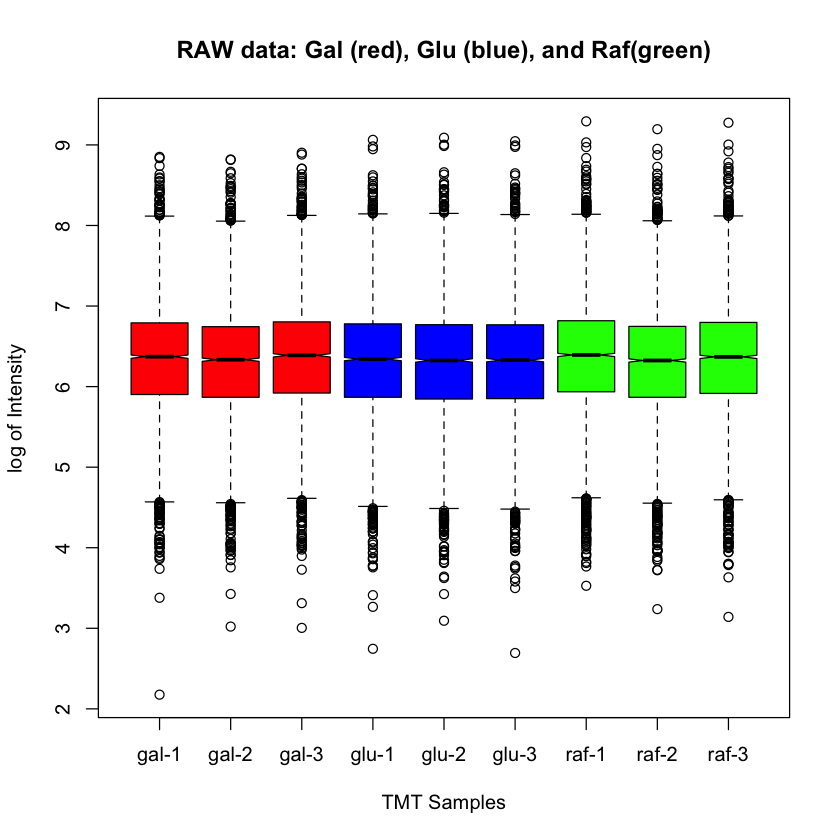

In [5]:
# let's see what the starting data look like
# set a 3 by 3 color vector
color_vector <- rep(c("red", "blue", "green"), each = 3)

# boxplots of RAW log intensities
boxplot(log10(tmt_raw), col = color_vector, 
        notch = TRUE, main = "RAW data: Gal (red), Glu (blue), and Raf(green)",
        xlab = "TMT Samples", ylab = "log of Intensity")

## Sample Loading (SL) normalization

The boxplots above already look excellent and we have not done any normalizations. We can compute normalization factors to make each column of reporter ion intensities sum to the same value. We loaded equal amounts of labeled protein digests, so we should have equal sums of reporter ions (in a perfect world). Large correction factors might imply a problem with the labeling for that channel.

In [6]:
SL_Norm <- function(df) {
    # This makes each channel sum to the average grand total
        # df - data frame of TMT intensities
        # returns a new data frame with normalized values
    norm_facs <- mean(c(colSums(df))) / colSums(df)
    cat("SL Factors:\n", sprintf("%-5s -> %f\n", colnames(df), norm_facs))
    df_sl  <- sweep(df, 2, norm_facs, FUN = "*")
}

# normalize the raw data
tmt_sl <- SL_Norm(tmt_raw)

SL Factors:
 gal-1 -> 1.024087
 gal-2 -> 1.121015
 gal-3 -> 0.975850
 glu-1 -> 1.032241
 glu-2 -> 1.033960
 glu-3 -> 1.046772
 raf-1 -> 0.868234
 raf-2 -> 1.033342
 raf-3 -> 0.912418


### We can also visualize the SL normalized data

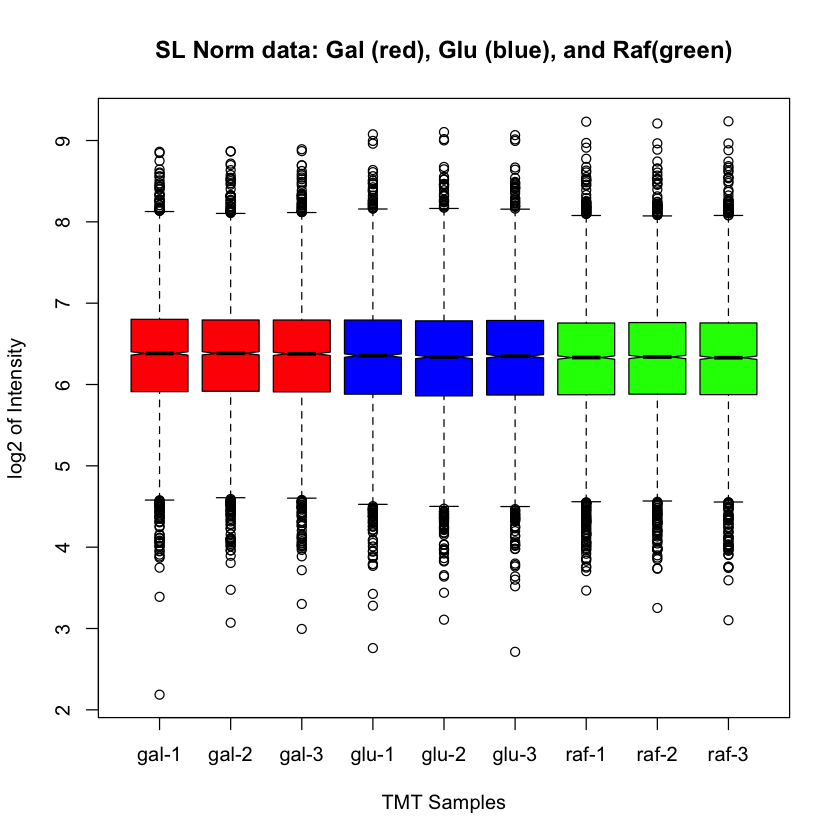

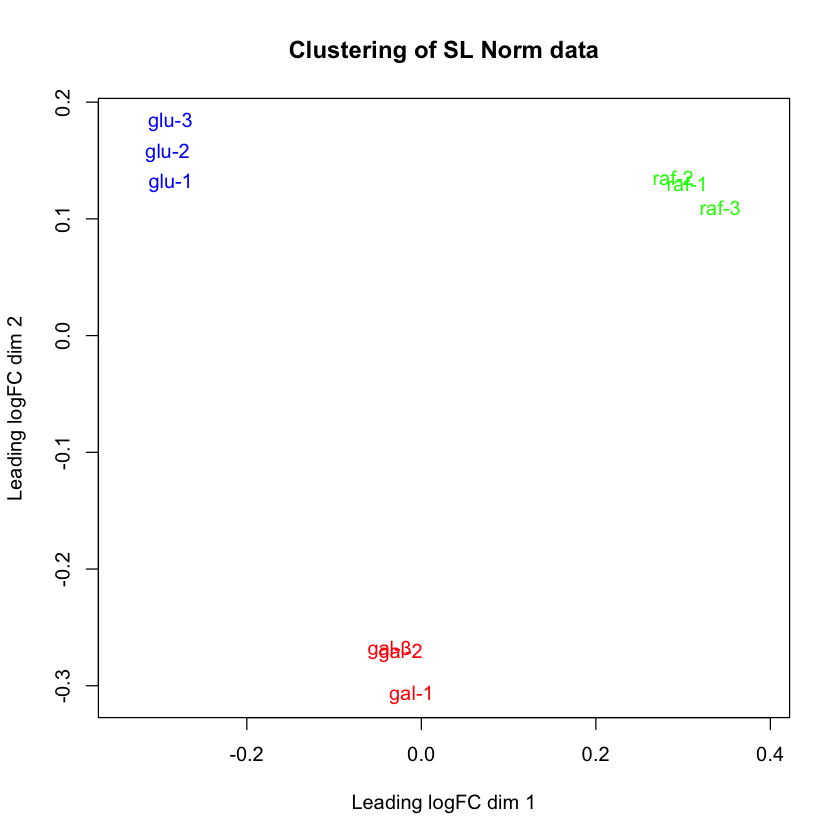

In [7]:
# let's see what the SL normalized data look like
boxplot(log10(tmt_sl), col = color_vector, 
        notch = TRUE, main = "SL Norm data: Gal (red), Glu (blue), and Raf(green)",
        xlab = "TMT Samples", ylab = "log2 of Intensity")

# and check clustering
plotMDS(log10(tmt_sl), col = color_vector, main = "Clustering of SL Norm data")

### Clustering looks great and SL correction factors were all close to 1

Boxplots are nicely aligned after the SL Norm step. All of the normalization factors were close to 1.0. The cluster plot shows tight grouping by condition and large separations between conditions. There should be some very clear differential expression candidates between conditions.

## Load edgeR data structures and normalize data using TMM

In [8]:
# load data, study design, and row labels into edgeR object
group <- rep(c("gal", "glu", "raf"), each = 3)
y <- DGEList(counts = tmt_raw, group = group, genes = accession)

# run TMM normalization
y <- calcNormFactors(y) 
y$samples

group lib.size    norm.factors
gal-1 gal   39546270758 1.0823799   
gal-2 gal   36126921134 1.0920935   
gal-3 gal   41501059458 1.0717689   
glu-1 glu   39233881101 1.0017027   
glu-2 glu   39168650488 0.9636187   
glu-3 glu   38689238723 0.9808195   
raf-1 raf   46645077775 0.9340568   
raf-2 raf   39192067280 0.9500346   
raf-3 raf   44386284708 0.9395360

### Check the TMM normalization results

TMM normalization factors were all very close to 1.0. We can get the norm factors from the DGEList object and create the normalized reporter ion intensities. EdgeR does not return adjusted intensities; the factors are used internally in the modeling. We can compute the adjusted values and save them. We can repeat the cluster and boxplot visualizations on the TMM normalized data.

In [9]:
apply_tmm_factors <- function(y) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute grand total (library size) scalings
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size

    # the TMM factors are library adjustment factors (so divide by them)
    norm_facs <- lib_facs / y$samples$norm.factors

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(tmt_raw), "_tmm")
    
    # return the data frame
    tmt_tmm
}
tmt_tmm <- apply_tmm_factors(y)

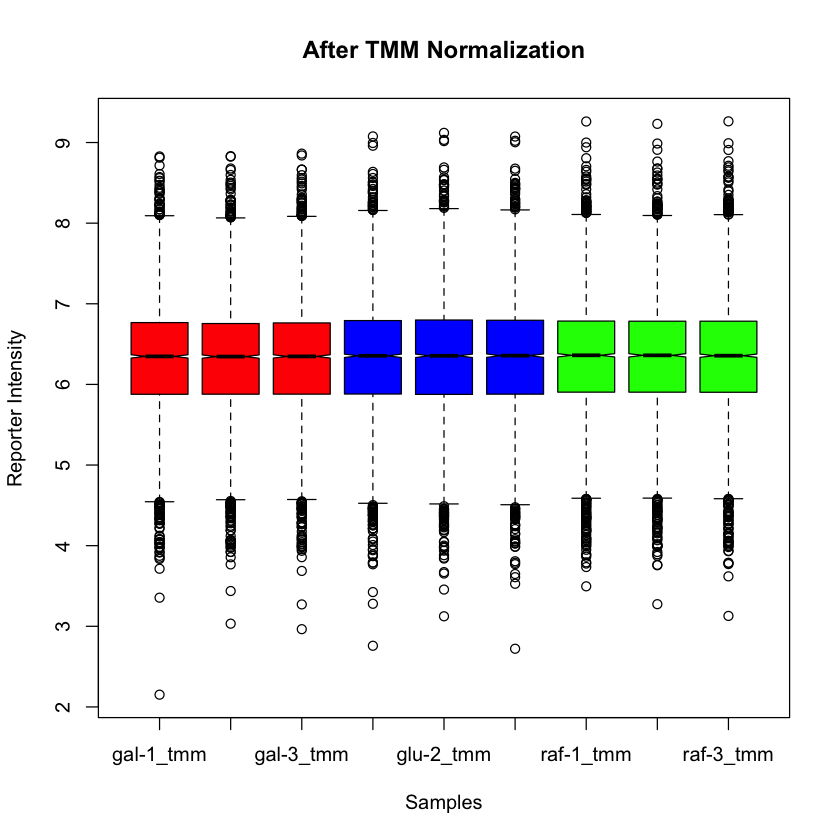

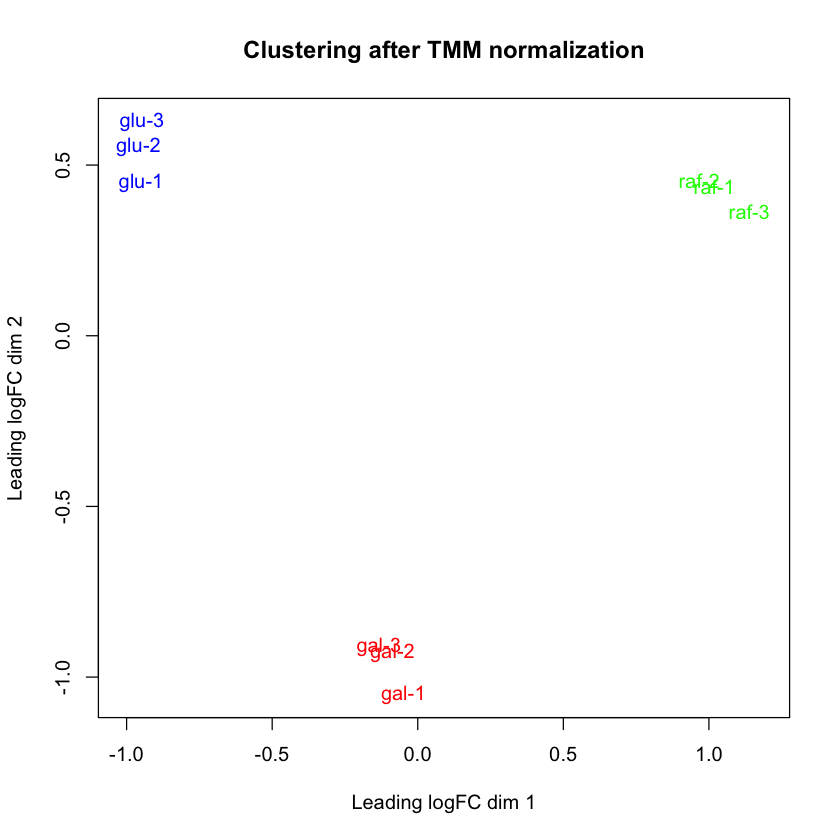

In [10]:
# look at intensity distributions across samples after TMM
boxplot(log10(tmt_tmm), 
        col = color_vector,
        xlab = "Samples", ylab = "Reporter Intensity", 
        main = "After TMM Normalization", notch = TRUE)

# check clustering after TMM with MDS plot
plotMDS(y, col = color_vector, main = "Clustering after TMM normalization")

### Hard to see if TMM did much...

Boxplots and clustering look pretty similar between SL Norm and TMM Norm. About all I can see is that the MDS plot axes ranges are a bit larger after TMM, indicating a little bigger difference between groups after TMM compared to SL norm.


## Sample-to-sample scatter plots are also useful

We can see how similar samples are to each other (within and between groups) using a multiple panel scatter plot visualization. The first three are the galactose carbon source, the next three are glucose, and the last three are raffinose.

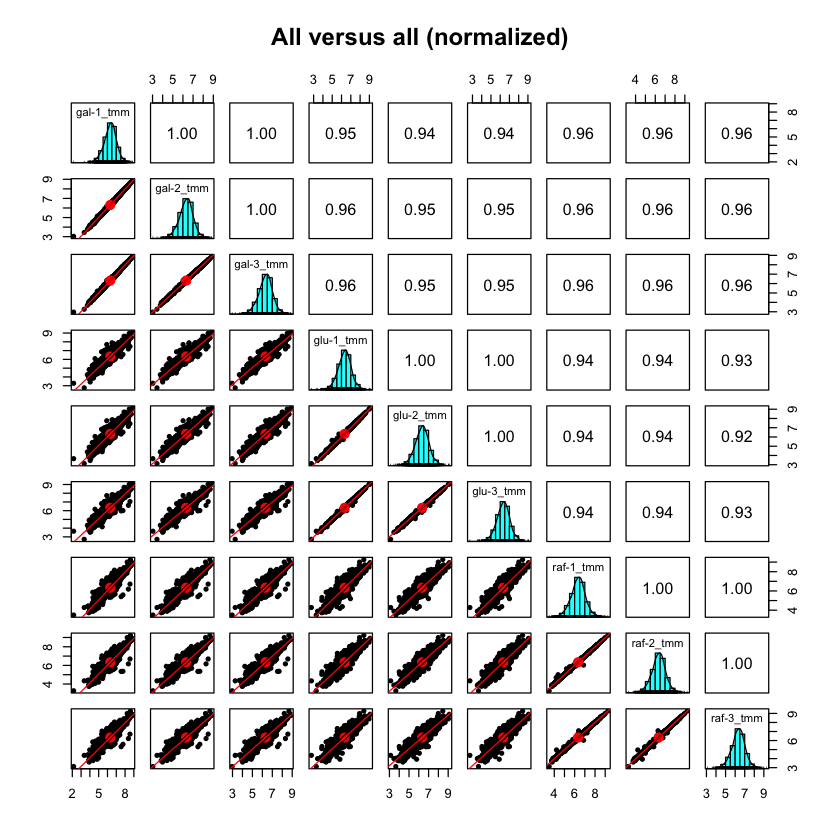

In [11]:
# compare all samples to each other
pairs.panels(log10(tmt_tmm), method = "spearman", 
             lm = TRUE, main = "All versus all (normalized)")

### Clustering and scatter plots indicate large differences between groups

The scatter plots indicate superb sample-to-sample reproducibility with the same condition (carbon source), and very significant differences between groups. The correlation coefficients within conditions are all 1.00 and coefficients between groups in the 0.92 to 0.96 range. Although the plots look quite different between conditions, the correlation coefficients are still very close to 1. Correlation coefficients are not a very sensitive metric. 

### Samples are in blocks of three

In [12]:
# save the indexes of each condition
gal <- 1:3
glu <- 4:6
raf <- 7:9

## CV distributions show how similar biological replicates are

We can use distributions of protein coefficients of variance (CV) to quantify how similar the samples within groups are. Using a little helper function, we can make boxplots of various sample groups. I will look at the CVs for each group before and after TMM normalization. The CVs are in percent.

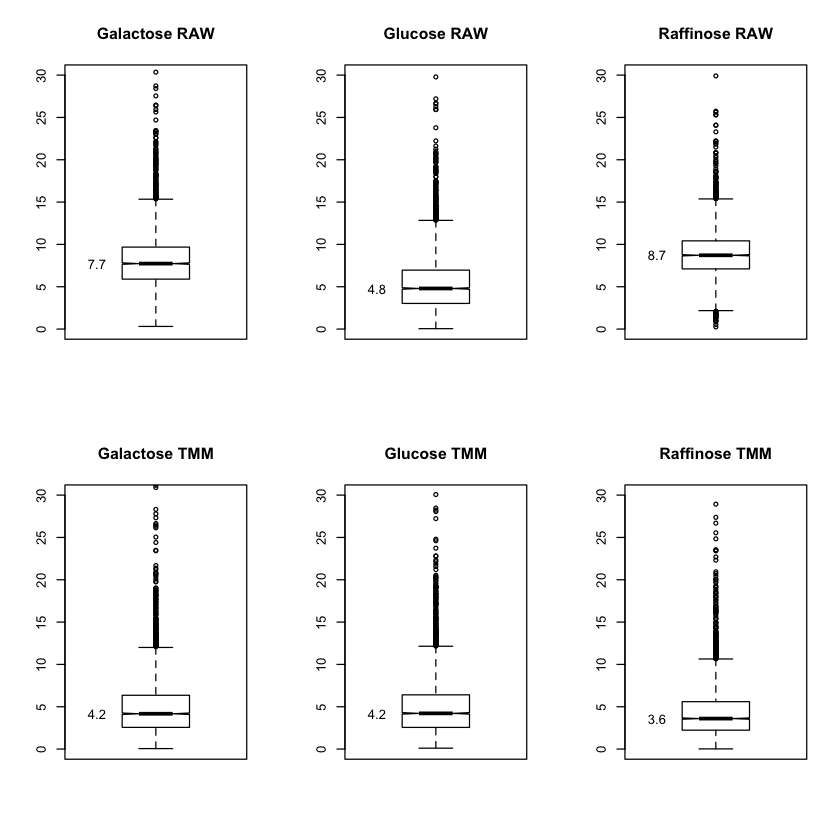

In [13]:
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

# make CV distributions for each condition before and after normalization
par(mfrow = c(2, 3))

labeled_boxplot(tmt_raw[gal], 30, "Galactose RAW")
labeled_boxplot(tmt_raw[glu], 30, "Glucose RAW")
labeled_boxplot(tmt_raw[raf], 30, "Raffinose RAW")
labeled_boxplot(tmt_tmm[gal], 30, "Galactose TMM")
labeled_boxplot(tmt_tmm[glu], 30, "Glucose TMM")
labeled_boxplot(tmt_tmm[raf], 30, "Raffinose TMM")

par(mfrow = c(1, 1))

### How "tight" are the CV distributions?

Median CVs were improved by TMM normalization for all three conditions. The sizes of the boxes (inter-quartile ranges) are also pretty small. It might be useful to see the full distributions.

Gal - 90% of CVs less than: 8.94 %
Glu - 90% of CVs less than: 9.15 %
Raf - 90% of CVs less than: 8.25 %


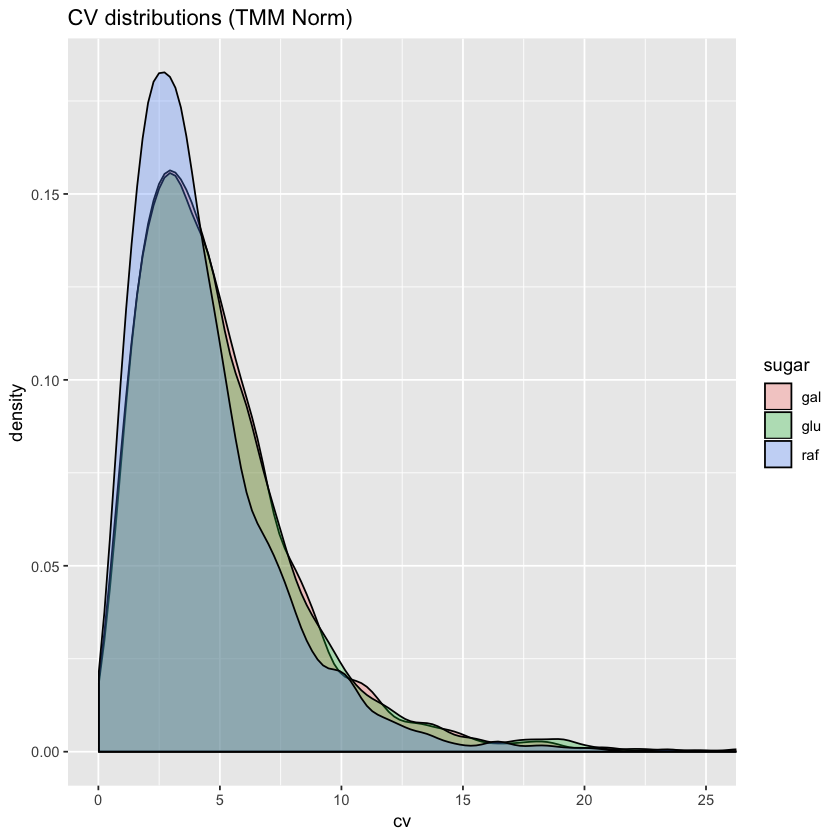

In [14]:
# print CV cutoffs that cature 90% of the proteins
cat("Gal - 90% of CVs less than:", round(quantile(CV(tmt_tmm[gal]), probs = 0.9), 2), "%\n")
cat("Glu - 90% of CVs less than:", round(quantile(CV(tmt_tmm[glu]), probs = 0.9), 2), "%\n")
cat("Raf - 90% of CVs less than:", round(quantile(CV(tmt_tmm[raf]), probs = 0.9), 2), "%\n")

# make a tidy data frame for plotting
cv_gal <- data.frame(cv = CV(tmt_tmm[gal]), sugar = "gal", stringsAsFactors = FALSE)
cv_glu <- data.frame(cv = CV(tmt_tmm[glu]), sugar = "glu", stringsAsFactors = FALSE)
cv_raf <- data.frame(cv = CV(tmt_tmm[raf]), sugar = "raf", stringsAsFactors = FALSE)
cv_long <- rbind(cv_gal, cv_glu, cv_raf)

# density plots
ggplot(cv_long, aes(x = cv, fill = sugar)) +
  geom_density(alpha = 0.3) +
  coord_cartesian(xlim = c(0, 25)) +
  ggtitle("CV distributions (TMM Norm)")

### 90% of the proteins have CVs less than about 9%

Yeast is a nice sample to work with and there was pretty extensive fractionation. Aggregating all of the PSMs into protein totals might be significantly improving the data. Just what degree of aggregation do we have?

## Distributions of the numbers of PSMs per protein

We added the usable PSMs per protein number to the data export. Usable means that the PSM was associated with a peptide that was mapped to one protein group in the final list of identifications.

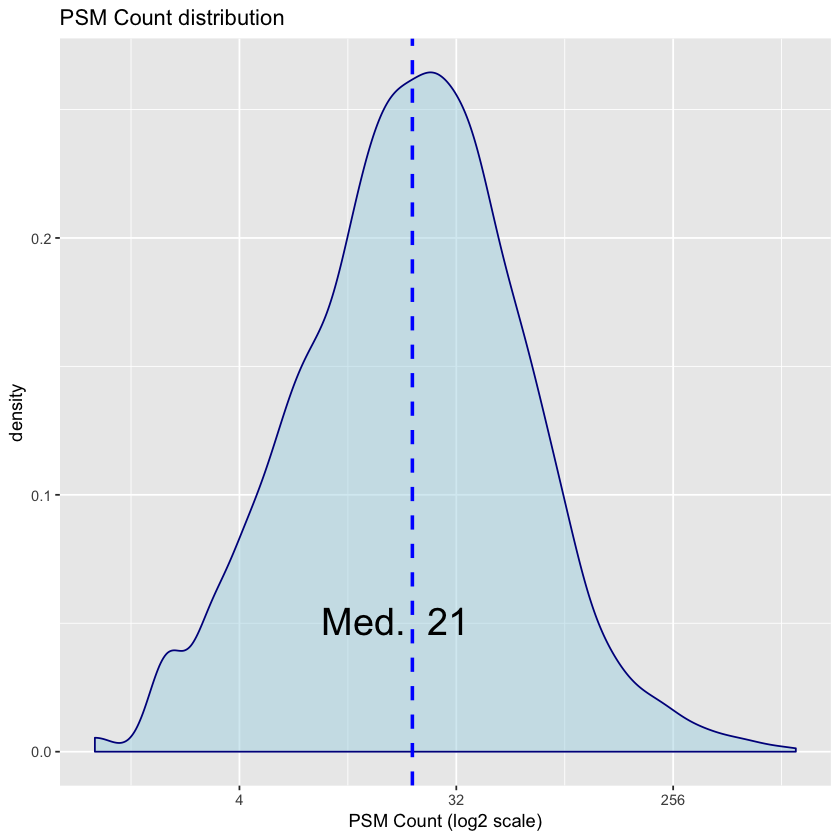

In [15]:
# plot distribution of PSMs per protein
p <- ggplot(as.data.frame(psm_counts), aes(x = psm_counts)) +
  geom_density(color = "darkblue", fill = "lightblue", alpha = 0.5) +
  scale_x_continuous(trans = "log2") +
  ggtitle("PSM Count distribution") +
  xlab("PSM Count (log2 scale)")

# add label at median
p + geom_vline(aes(xintercept=median(psm_counts)), color="blue", linetype="dashed", size=1) +
  annotate(geom = "text", x = 17.9, y = 0.0508, label = str_c("Med.  ", median(psm_counts)), size = 8)

In [16]:
# where is the lower end of the data?
quantile(psm_counts, prob = .05)

5% 
 3

### Numbers of PSMs per protein are large

The median number of PSMs per protein is 21. In fact, 95% of all of the proteins have more than 3 summed PSMs. The data quality for this experiment is extremely high. 

# Main statistical testing

We will do pairwise exact tests in edgeR. We have already loaded data into a DGEList object (above) and ran the TMM normalization. We need to get the global dispersion estimates before doing the pairwise exact statistical testing.

Design matrix not provided. Switch to the classic mode.


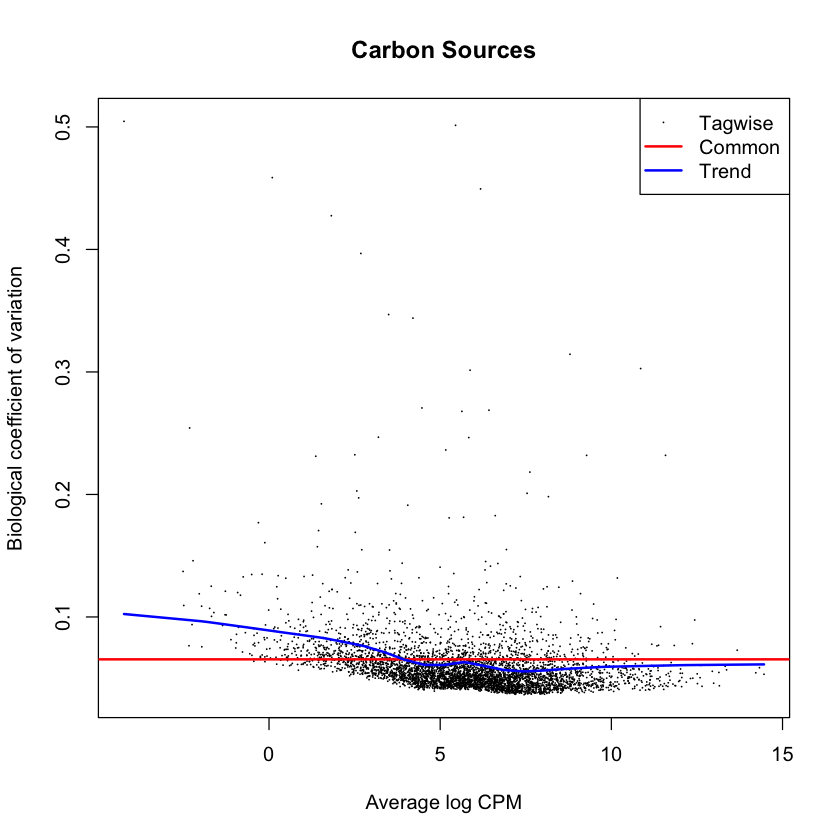

In [17]:
# compute the shared variance estimates and plot variance trends
y <- estimateDisp(y)
plotBCV(y, main = "Carbon Sources")

## Do the Galactose versus Glucose comparison first

We will save some average condition intensity vectors (for plotting purposes), compute the statistical models, save the results, and see what the top differential candidates are.

In [18]:
collect_results <- function(df, tt, x, xlab, y, ylab) {
    # Computes new columns and extracts some columns to make results frame
        # df - data in data.frame
        # tt - top tags from edgeR test
        # x - columns for first condition
        # xlab - label for x
        # y - columns for second condition
        # ylab - label for y
        # returns a new dataframe
    
    # condition average vectors
    ave_x <- rowMeans(df[x])
    ave_y <- rowMeans(df[y])
    
    # FC, direction, candidates
    fc <- ifelse(ave_y > ave_x, (ave_y / ave_x), (-1 * ave_x / ave_y))
    direction <- ifelse(ave_y > ave_x, "up", "down")
    candidate = cut(tt$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                    labels = c("high", "med", "low", "no"))
    
    # make data frame
    temp <- cbind(df[c(x, y)], data.frame(logFC = tt$logFC, FC = fc, 
                                          PValue = tt$PValue, FDR = tt$FDR, 
                                          ave_x = ave_x, ave_y = ave_y, 
                                          direction = direction, candidate = candidate, 
                                          Acc = tt$genes)) 
    
    # fix column headers for averages
    names(temp)[names(temp) %in% c("ave_x", "ave_y")]  <- str_c("ave_", c(xlab, ylab))    
    
    temp # return the data frame
}

In [19]:
# compute the exact test models, p-values, FC, etc.
et <- exactTest(y, pair = c("gal", "glu"))

# see which proteins have the smallest p-values
topTags(et)$table

# make the results table 
tt <- topTags(et, n = Inf, sort.by = "none")$table
gal_glu <- collect_results(tmt_tmm, tt, gal, "gal", glu, "glu")

genes                 logFC     logCPM   PValue        FDR          
4397 sp|Q12289|CRC1_YEAST   3.996314 7.229292  0.000000e+00  0.000000e+00
889  sp|P28240|ACEA_YEAST   3.839650 9.856680  0.000000e+00  0.000000e+00
3279 sp|P80235|CACM_YEAST   3.277484 7.833201  0.000000e+00  0.000000e+00
2124 sp|P40017|YAT2_YEAST   2.979162 8.636449  0.000000e+00  0.000000e+00
1215 sp|P32907|ATO2_YEAST   2.786870 4.112160  0.000000e+00  0.000000e+00
3325 sp|Q01574|ACS1_YEAST   2.250014 8.775355 9.876590e-298 7.674110e-295
2436 sp|P41939|IDHC_YEAST   3.017683 7.751381 1.160767e-293 7.730710e-291
246  sp|P08679|CISY2_YEAST  3.126243 8.119938 3.839939e-277 2.237725e-274
4404 sp|Q12303|YPS3_YEAST  -2.662002 4.550710 2.302546e-249 1.192719e-246
463  sp|P16467|PDC5_YEAST   3.254347 5.745279 1.542582e-242 7.191517e-240

### Is the test appropriate for this data?

The p-value distribution is way to check that the data and the statistical test are compatible (not necessarily correct). We should have a flat distribution from non-differentially expressed candidates at larger p-values and an increase at small p-values from true candidates.

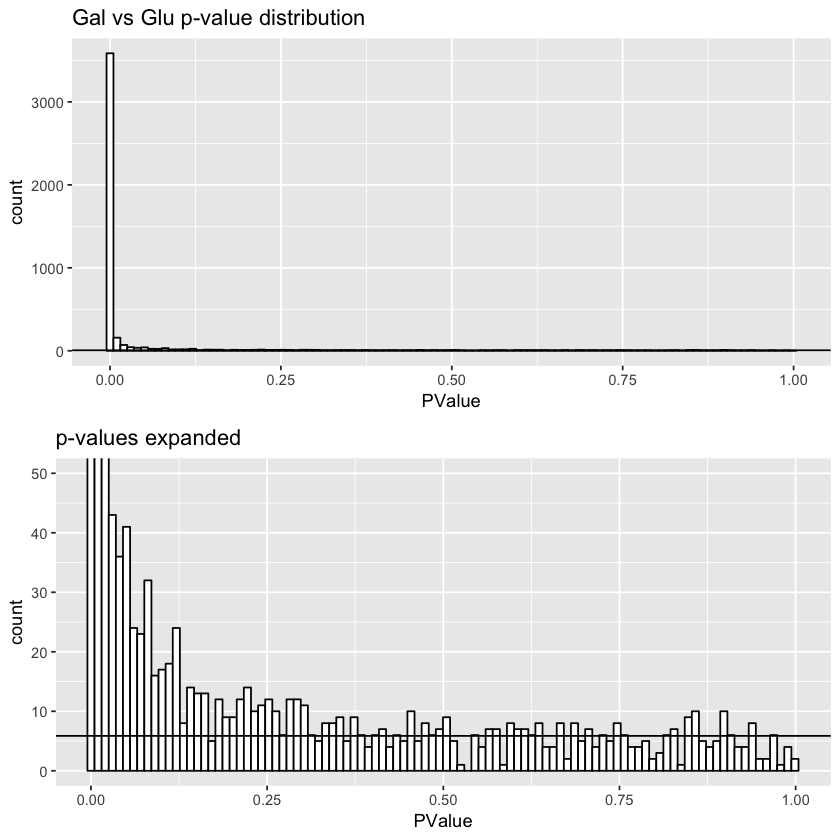

In [20]:
pvalue_plots <- function(results, ylim, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # ylim - ymax for expanded view
        # title - plot title
    p_plot <- ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100]))

    # we will need an expanded plot
    p1 <- p_plot + ggtitle(str_c(title, " p-value distribution"))
    p2 <- p_plot + coord_cartesian(xlim = c(0, 1.0), ylim = c(0, 50)) + ggtitle("p-values expanded")
    grid.arrange(p1, p2, nrow = 2) # from gridExtra package
}

# check the p-value distribution
pvalue_plots(gal_glu, 50, "Gal vs Glu")

### P-value distribution looks good

The peak at small p-values from true differential expression candidates is dominant. We sort of have a flat distribution of larger p-values, but we had to expand the scale to see them.

### See how many DE candidates and visualize them

edgeR has some built-in functions for some quick checks of the statistical testing. We can get the number of up and down regulated proteins and make an MA plot of candidates. Up is over-expression in second condition (glu), down is over-expression in first condition (gal).

       glu-gal
Down      2019
NotSig     649
Up        1994

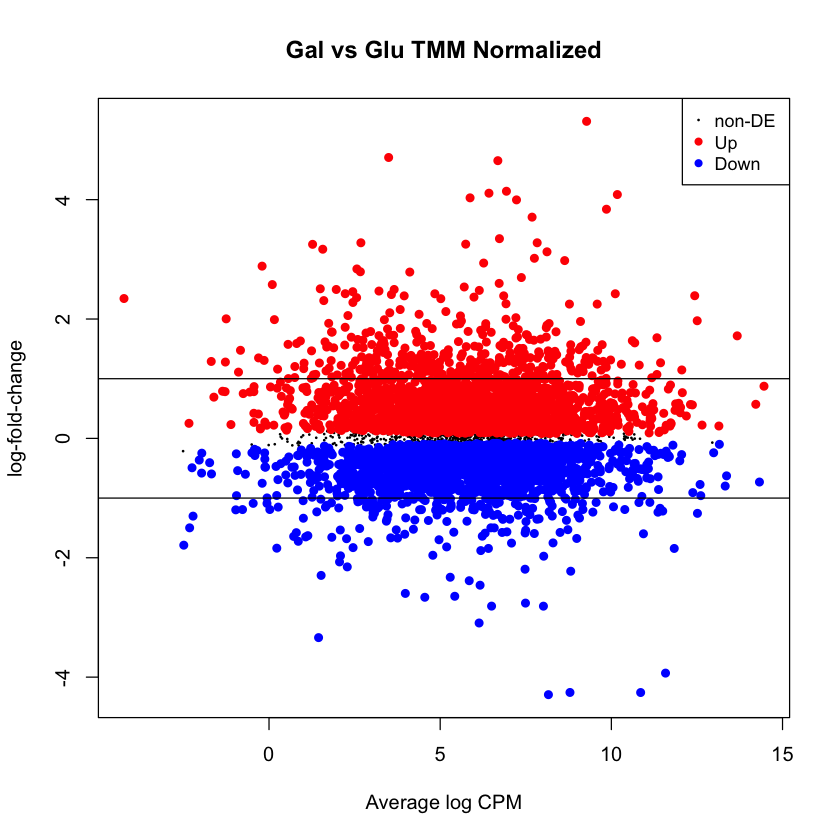

In [21]:
# see how many up and down candidates (10% FDR)
summary(decideTests(et, p.value = 0.10))

# use function from limma for MD plot
plotMD(et, main = "Gal vs Glu TMM Normalized", p.value = 0.10)
abline(h = c(-1, 1), col = "black")

### We can also make some other plots

ggplot2 can make some nicer looking plots with modern colors and design elements, and gives us some options for exploring categories (color and symbols by category, and multi-panel facet plots).

candidate n   
1 high      3651
2 med        230
3 low        132
4 no         649

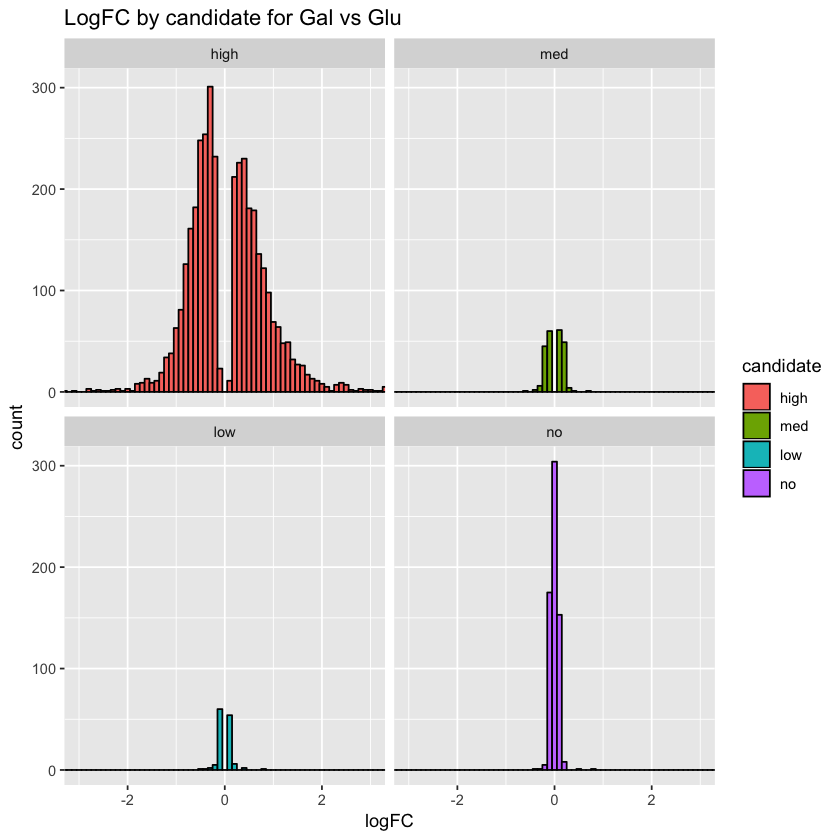

In [22]:
# see how many candidates are in each category
gal_glu %>% count(candidate)

log2FC_plots <- function(results, range, title) {
    # Makes faceted log2FC plots by candidate
        # results - results data frame
        # range - plus/minus log2 x-axis limits
        # title - plot title
    ggplot(results, aes(x = logFC, fill = candidate)) +
        geom_histogram(binwidth=0.1, color = "black") +
        facet_wrap(~candidate) +
        ggtitle(title) + 
        coord_cartesian(xlim = c(-range, range))
}

# can also look at log2FC distributions
log2FC_plots(gal_glu, 3, "LogFC by candidate for Gal vs Glu")

### Up and down expression is pretty balanced

From the edgeR summaries and MA plot, there is good balance between up and down regulation. We also see that in the logFC plots above.

### Make a plotting function (we will need to call this 3 times)

In [23]:
transform <- function(results, x, y) {
    # Make data frame with some transformed columns
        # results - results data frame
        # x - columns for x condition
        # y - columns for y condition
        # return new data frame
    df <- data.frame(log10((results[x] + results[y])/2), 
                     log2(results[y] / results[x]), 
                     results$candidate,
                     -log10(results$FDR))
    colnames(df) <- c("A", "M", "candidate", "P")
    
    df # return the data frame
}

MA_plots <- function(results, x, y, title) {
    # makes MA-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots 
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # 2-fold change lines
    ma_lines <- list(geom_hline(yintercept = 0.0, color = "black"),
                     geom_hline(yintercept = 1.0, color = "black", linetype = "dotted"),
                     geom_hline(yintercept = -1.0, color = "black", linetype = "dotted"))

    # make main MA plot
    ma <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("logFC (", y, "/", x, ")")) +
        scale_x_continuous("Ave_intensity") +
        ggtitle(title) + 
        ma_lines
    
    # make separate MA plots
    ma_facet <- ggplot(temp, aes(x = A, y = M)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scale_y_continuous(paste0("log2 FC (", y, "/", x, ")")) +
        scale_x_continuous("log10 Ave_intensity") +
        ma_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)"))

    # make the plots visible
    print(ma)
    print(ma_facet)
}    

scatter_plots <- function(results, x, y, title) {
    # makes scatter-plot DE candidate ggplots
        # results - data frame with edgeR results and some condition average columns
        # x - string for x-axis column
        # y - string for y-axis column
        # title - title string to use in plots
        # returns a list of plots
    
    # 2-fold change lines
    scatter_lines <- list(geom_abline(intercept = 0.0, slope = 1.0, color = "black"),
                          geom_abline(intercept = 0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          geom_abline(intercept = -0.301, slope = 1.0, color = "black", linetype = "dotted"),
                          scale_y_log10(),
                          scale_x_log10())

    # make main scatter plot
    scatter <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        ggtitle(title) + 
        scatter_lines

    # make separate scatter plots
    scatter_facet <- ggplot(results, aes_string(x, y)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        scatter_lines +
        facet_wrap(~ candidate) +
        ggtitle(str_c(title, " (separated)")) 

    # make the plots visible
    print(scatter)
    print(scatter_facet)
}

volcano_plot <- function(results, x, y, title) {
    # makes a volcano plot
        # results - a data frame with edgeR results
        # x - string for the x-axis column
        # y - string for y-axis column
        # title - plot title string
    
    # uses transformed data
    temp <- transform(results, x, y)
    
    # build the plot
    ggplot(temp, aes(x = M, y = P)) +
        geom_point(aes(color = candidate, shape = candidate)) +
        xlab("log2 FC") +
        ylab("-log10 FDR") +
        ggtitle(str_c(title, " Volcano Plot"))
}

### Galactose versus Glucose MA plots

MA plots are commonly used in genomics studies to show expression levels and highlight DE candidates.

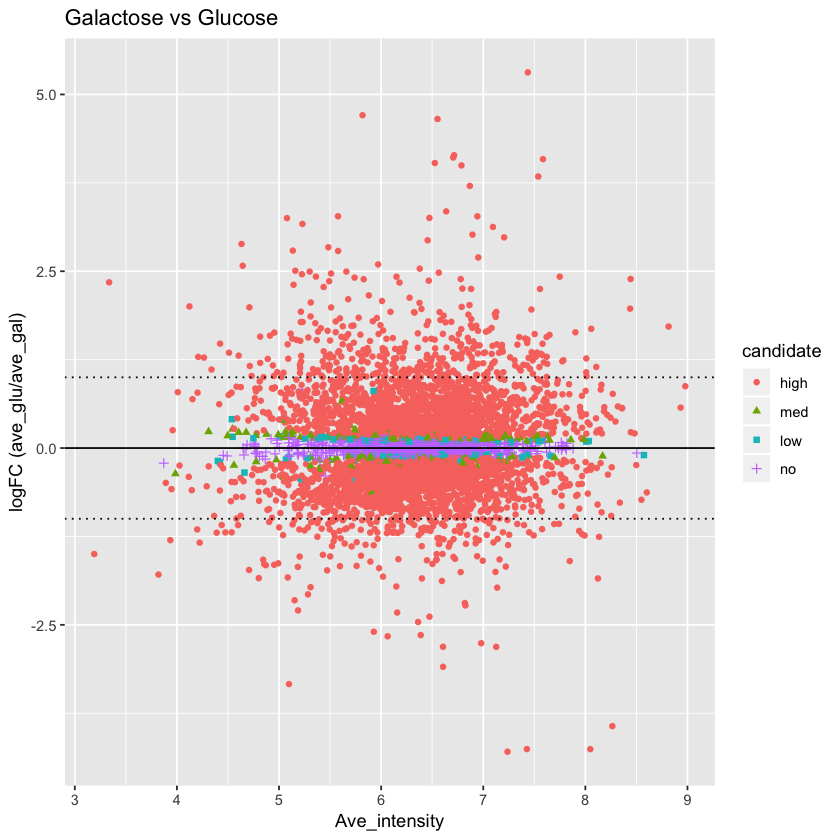

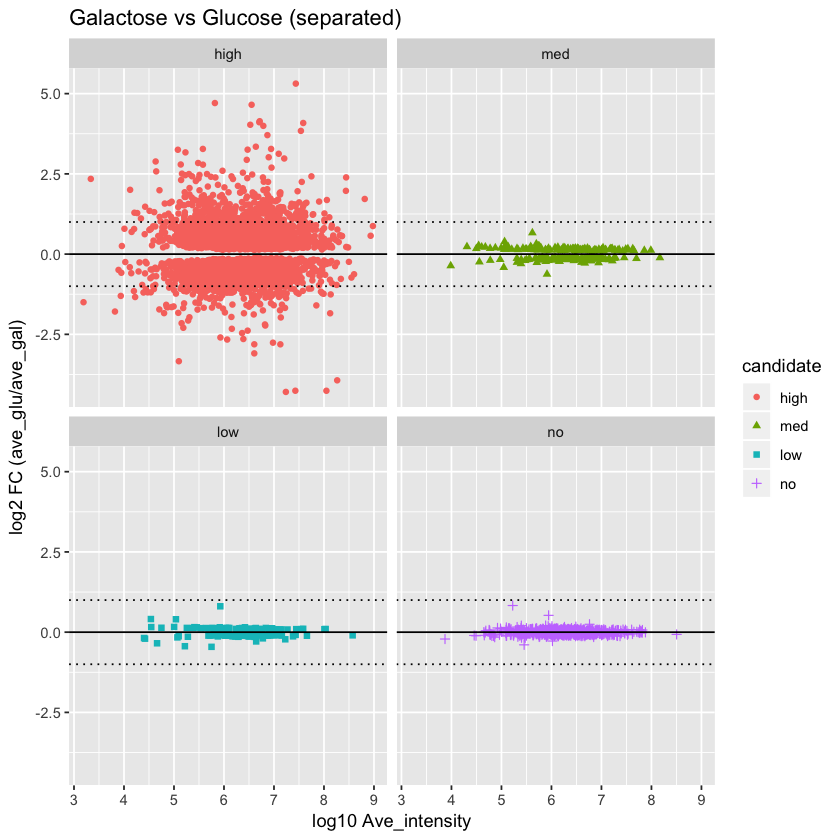

In [24]:
# do the gal vs glu MA visualizations
MA_plots(gal_glu, "ave_gal", "ave_glu", "Galactose vs Glucose")

### Same data visualized with scatter plots

Scatter plots and MA plots are very closely related. One thing I like about scatter plots is that both axes are in natural scales. Both axes are transformations of intensities for MA plots. The y-axis in MA plots will usually be auto scaled so that datasets with low or high variability often look similar. The scatter plots display dispersion in a more absolute way.

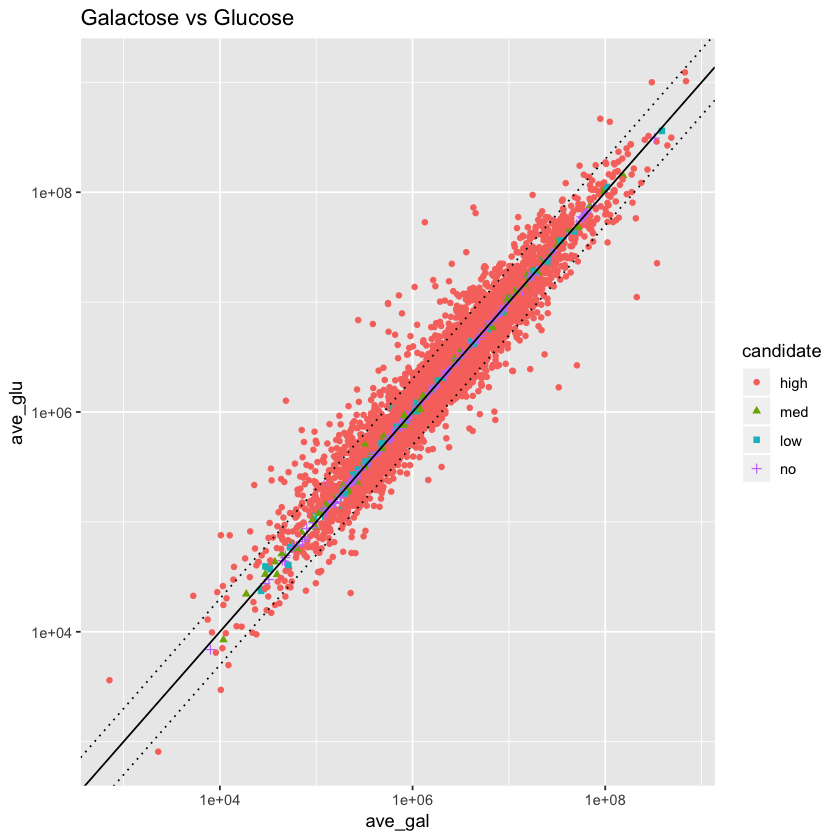

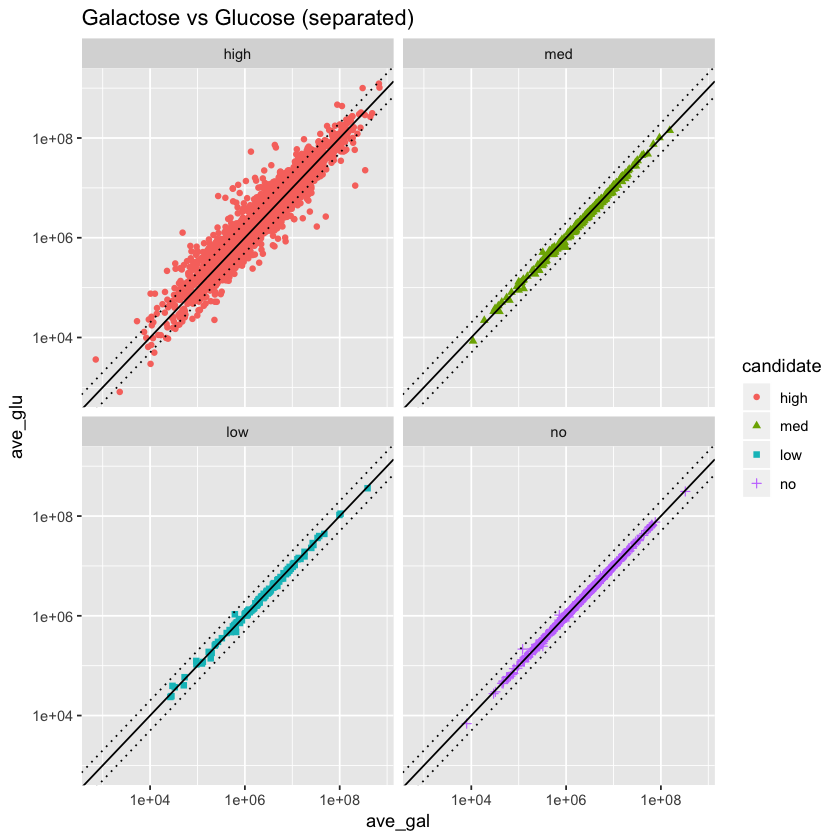

In [25]:
# same comparison with scatter plots
scatter_plots(gal_glu, "ave_gal", "ave_glu", "Galactose vs Glucose")

### And in a Volcano plot

I find volcano plots a less informative way to visualize DE data. That said, they are so commonly used that we will include them without further comments.

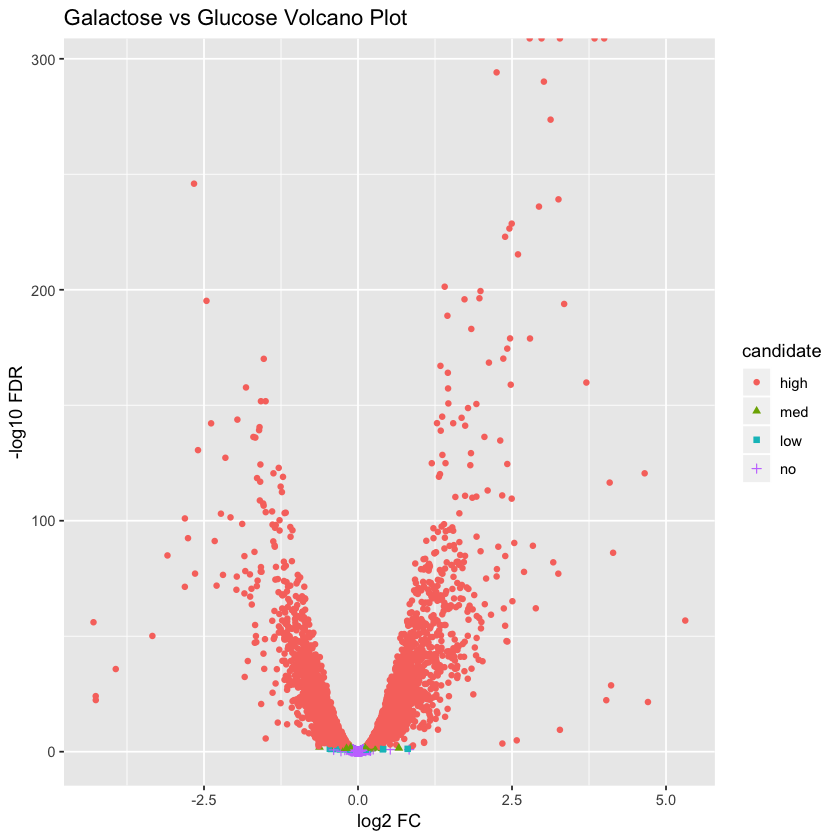

In [26]:
# the ubiquitous volcano plot
volcano_plot(gal_glu, "ave_gal", "ave_glu", "Galactose vs Glucose")

### Most of the proteins are DE candidates

The cluster plot gave us a heads up that there would be a lot of DE candidates. The CVs per condition are so low that even modest fold-changes have very low p-values. There are only 13.6% non-differentially expressed proteins (10% FDR with a BH multiple test correction). There are 79% of the proteins in the **high** category!

### Contrast within conditions to between conditions

Just to double check that the results make sense, we can do a multi-panel scatter plot grid of Gal versus Glu samples.

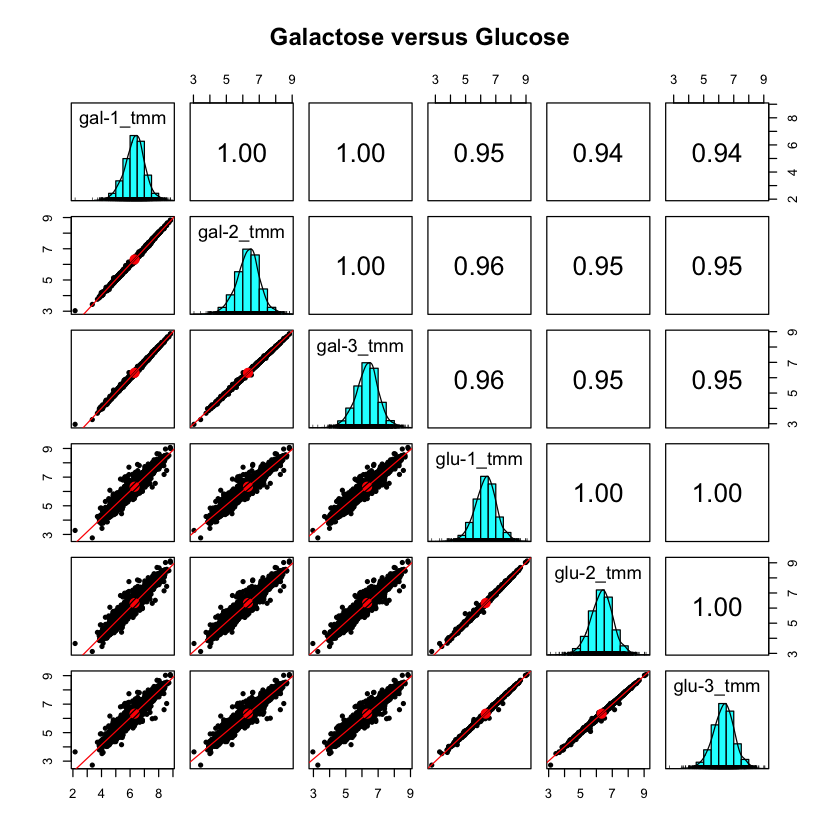

In [27]:
# compare the conditions to each other
pairs.panels(log10(tmt_tmm[c(gal, glu)]), method = "spearman", 
             lm = TRUE, main = "Galactose versus Glucose")

### Within conditions are very tight and between conditions have a lot of scatter

## Galactose versus Raffinose next

In [28]:
# compute the exact test models, p-values, FC, etc.
et <- exactTest(y, pair = c("gal", "raf"))

# see which proteins have the smallest p-values
topTags(et)$table

# get the results table 
tt <- topTags(et, n = Inf, sort.by = "none")$table
gal_raf <- collect_results(tmt_tmm, tt, gal, "gal", raf, "raf")

genes                 logFC     logCPM   PValue FDR
2202 sp|P40188|RGI2_YEAST   5.370839 6.723162 0      0  
3325 sp|Q01574|ACS1_YEAST   3.846427 8.775355 0      0  
1417 sp|P36035|JEN1_YEAST   3.817312 8.383256 0      0  
1215 sp|P32907|ATO2_YEAST   3.806278 4.112160 0      0  
432  sp|P15202|CATA_YEAST   3.176397 4.108292 0      0  
2197 sp|P40168|YNT5_YEAST   2.685894 5.436421 0      0  
98   sp|P04710|ADT1_YEAST   2.659014 6.730922 0      0  
56   sp|P01094|IPA3_YEAST   2.375761 8.525923 0      0  
504  sp|P18408|MET16_YEAST -2.325263 4.259014 0      0  
4018 sp|Q07500|NDH2_YEAST   2.286164 7.976351 0      0

### Check the p-value distribution

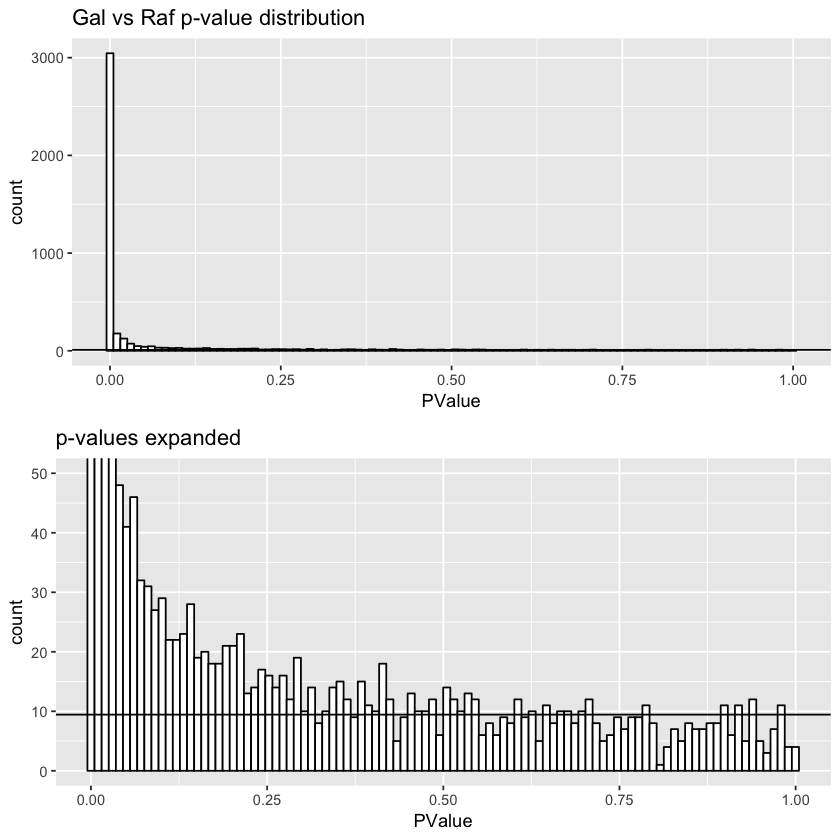

In [29]:
# check the p-value distribution
pvalue_plots(gal_raf, 50, "Gal vs Raf")

### P-value distribution looks okay

### Get candidate numbers and make an MA plot

       raf-gal
Down      1746
NotSig    1068
Up        1848

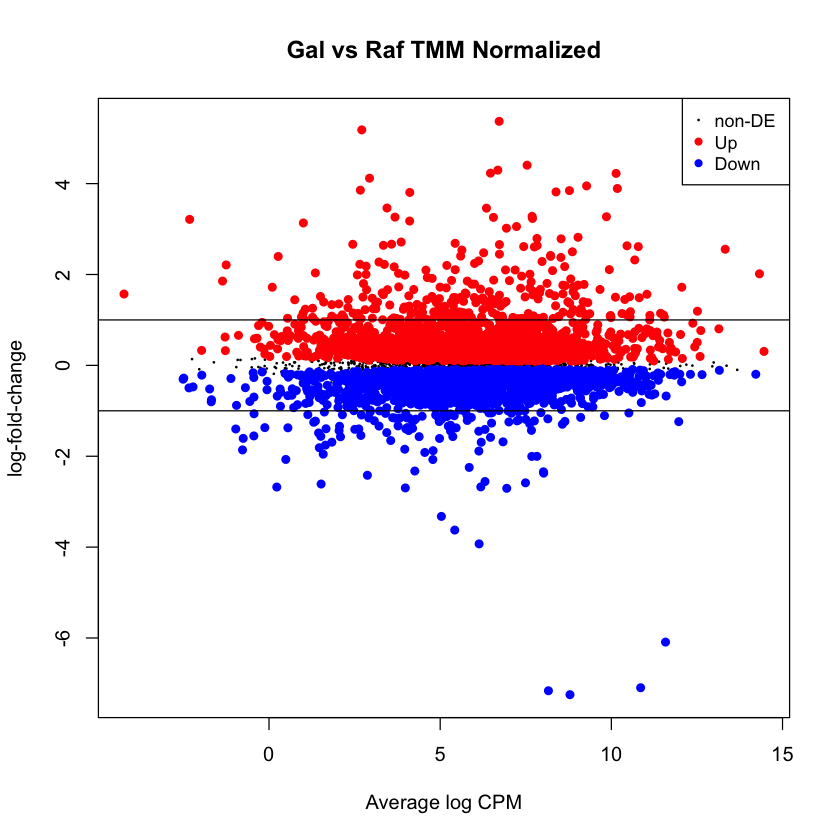

In [30]:
# see how many up and down candidates (10% FDR)
summary(decideTests(et, p.value = 0.10))

# use function from limma for MD plot
plotMD(et, main = "Gal vs Raf TMM Normalized", p.value = 0.10)
abline(h = c(-1, 1), col = "black")

### Counts by category and logFC plots

candidate n   
1 high      3096
2 med        334
3 low        164
4 no        1068

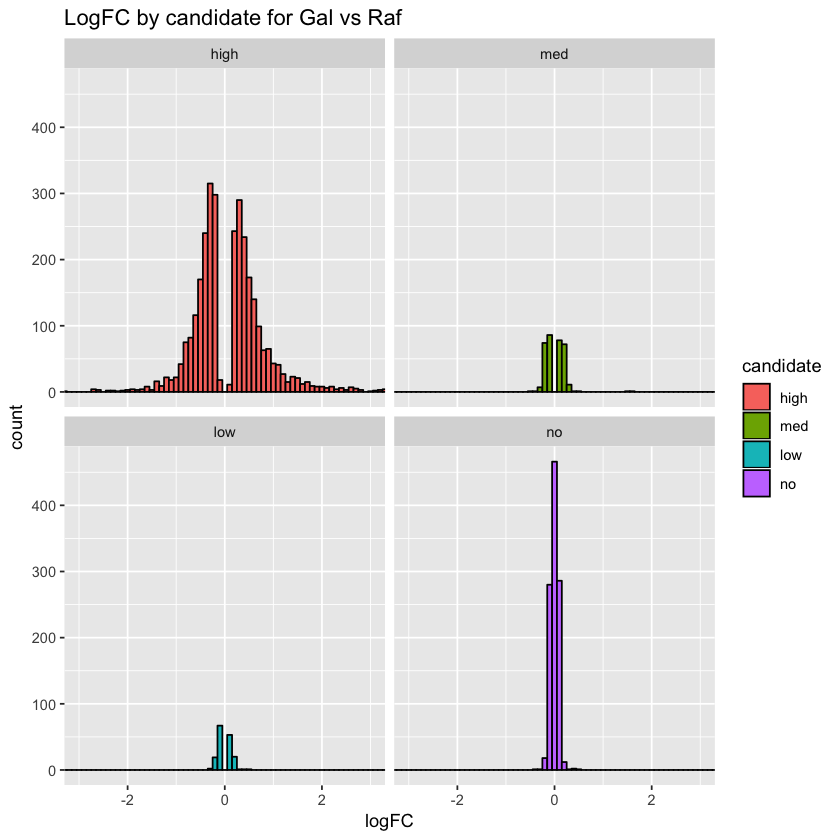

In [31]:
# see how many candidates are in each category
gal_raf %>% count(candidate)

# can also look at log2FC distributions
log2FC_plots(gal_raf, 3, "LogFC by candidate for Gal vs Raf")

### The ggplot MA plots

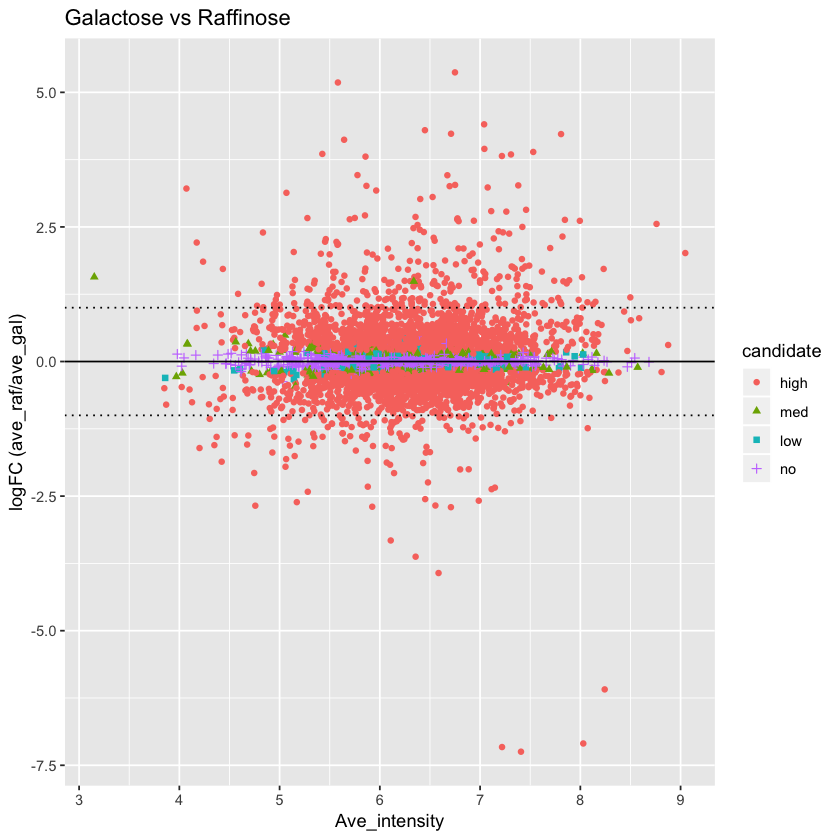

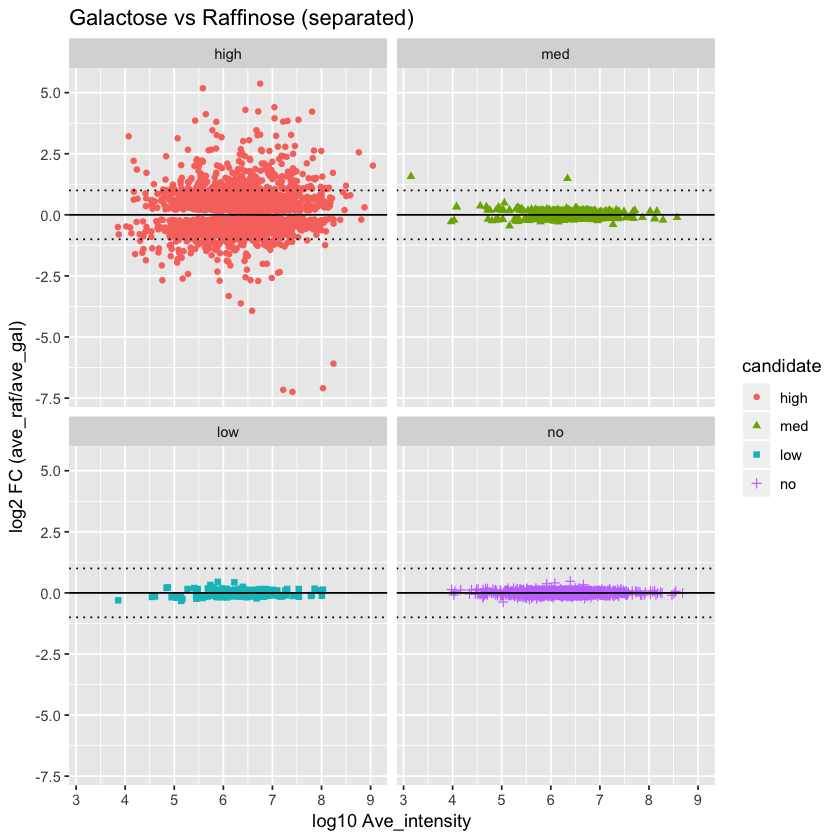

In [32]:
# make the MA plots
MA_plots(gal_raf, "ave_gal", "ave_raf", "Galactose vs Raffinose")

### Scatter plots next

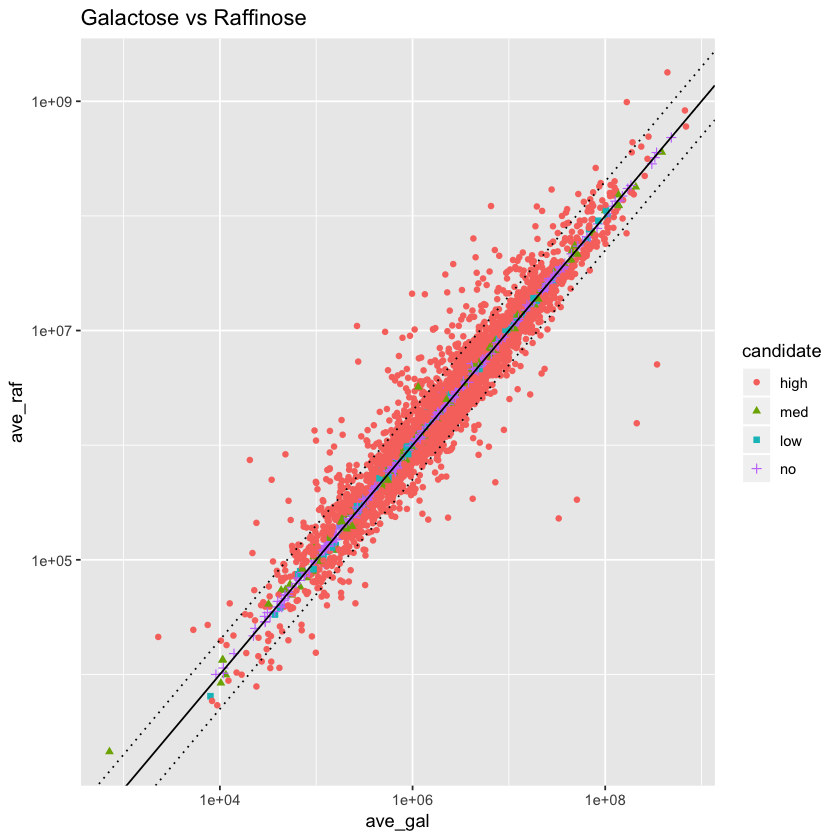

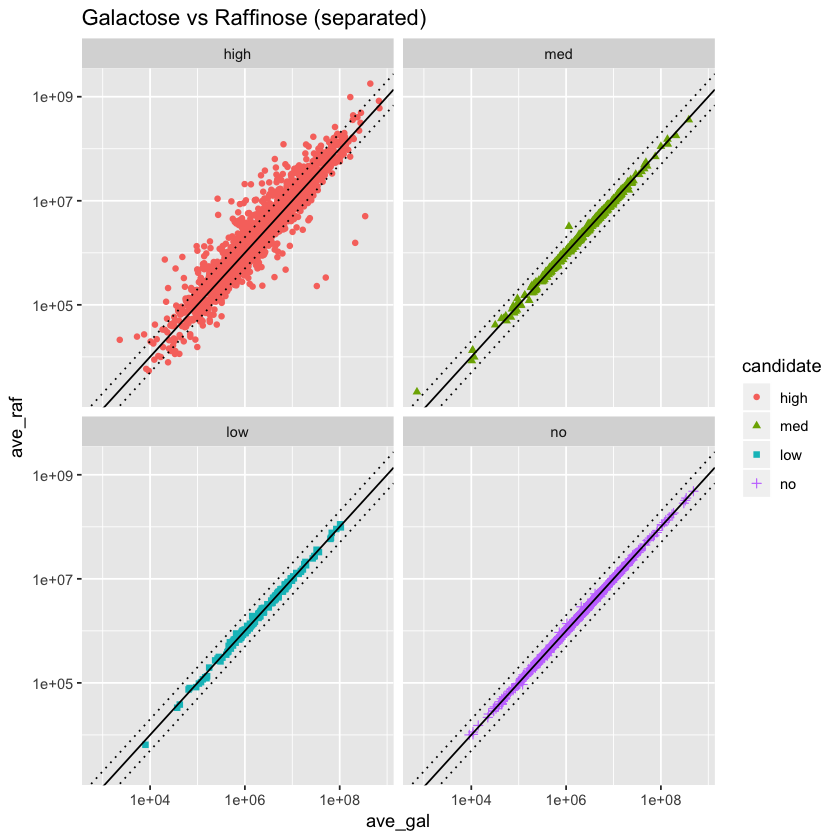

In [33]:
# scatter plots
scatter_plots(gal_raf, "ave_gal", "ave_raf", "Galactose vs Raffinose")

### And the Volcano plot

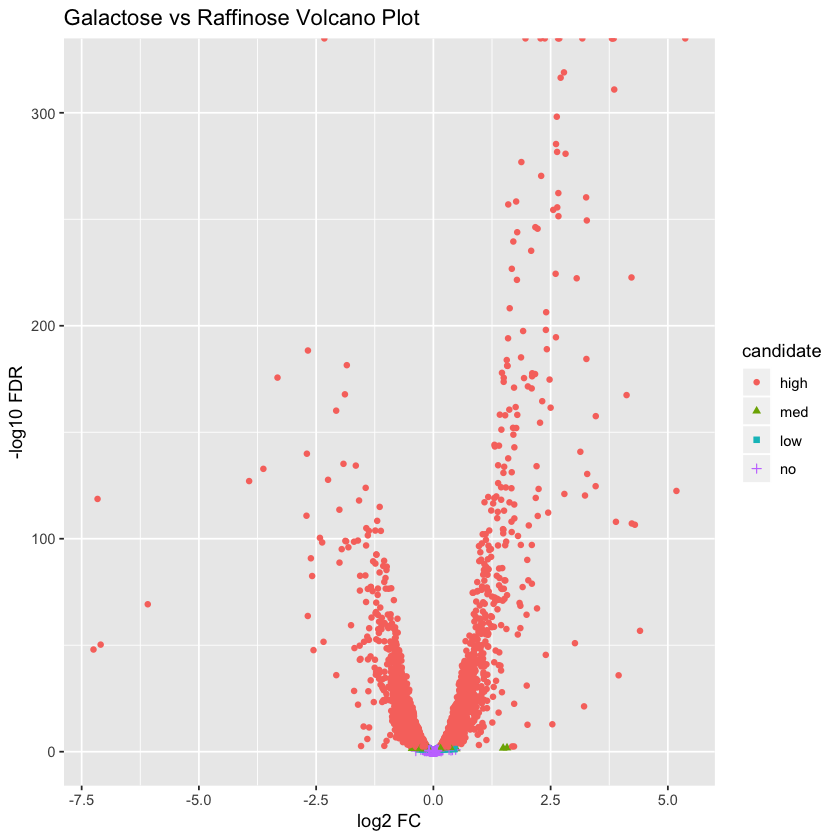

In [34]:
volcano_plot(gal_raf, "ave_gal", "ave_raf", "Galactose vs Raffinose")

### Similar pattern to Gal vs Glu comparison

We had a few more non-differentially expressed proteins in Gal vs Raf than we saw in the Gal vs Glu comparison. We still have an overwhelmingly large number of DE candidates.

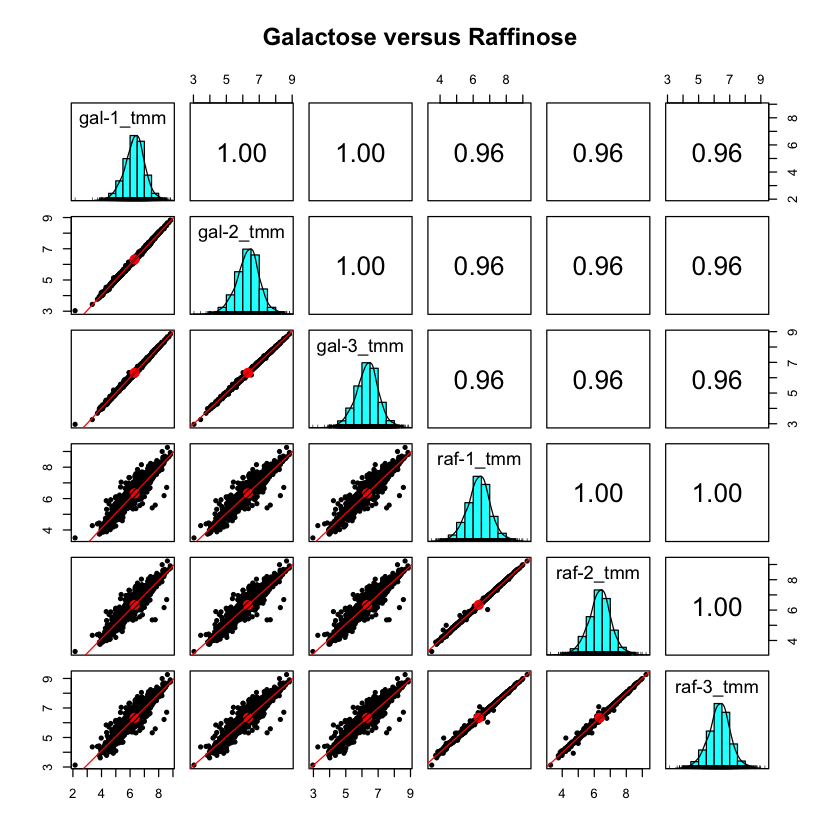

In [35]:
# compare the conditions to each other
pairs.panels(log10(tmt_tmm[c(gal, raf)]), method = "spearman", 
             lm = TRUE, main = "Galactose versus Raffinose")

### Within conditions are very tight and between conditions have a lot of scatter

## Finally, Glucose versus Raffinose

In [36]:
# compute the exact test models, p-values, FC, etc.
et <- exactTest(y, pair = c("glu", "raf"))

# see which proteins have the smallest p-values
topTags(et)$table

# get the results table 
tt <- topTags(et, n = Inf, sort.by = "none")$table
glu_raf <- collect_results(tmt_tmm, tt, glu, "glu", raf, "raf")

genes                 logFC    logCPM    PValue FDR
3689 sp|Q04487|SHH3_YEAST  3.560960  5.597708 0      0  
1250 sp|P33315|TKT2_YEAST  3.464846  8.226809 0      0  
98   sp|P04710|ADT1_YEAST  3.367039  6.730922 0      0  
658  sp|P22943|HSP12_YEAST 3.354535 13.325662 0      0  
2991 sp|P53228|TAL2_YEAST  3.105828  9.026934 0      0  
21   sp|P00175|CYB2_YEAST  3.091156  7.480814 0      0  
3057 sp|P53319|6PGD2_YEAST 2.929136  8.729230 0      0  
4018 sp|Q07500|NDH2_YEAST  2.833515  7.976351 0      0  
432  sp|P15202|CATA_YEAST  2.695979  4.108292 0      0  
977  sp|P32191|GPDM_YEAST  2.641967 10.392516 0      0

### Check p-values

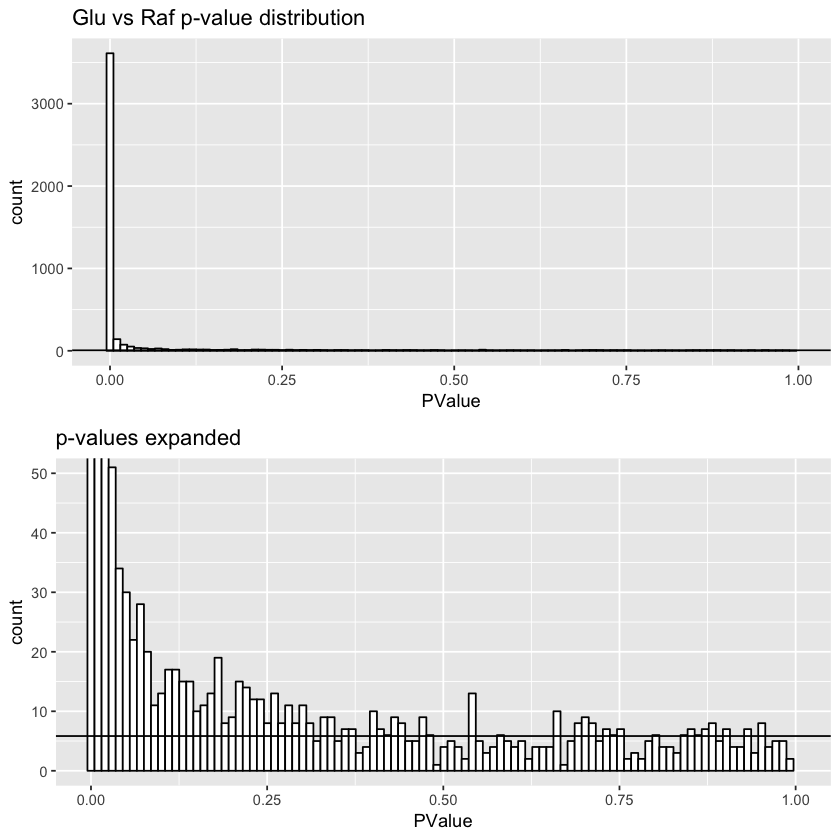

In [37]:
# check the p-value distribution
pvalue_plots(glu_raf, 50, "Glu vs Raf")

### Get candidate counts and make basic MA plot

       raf-glu
Down      1982
NotSig     648
Up        2032

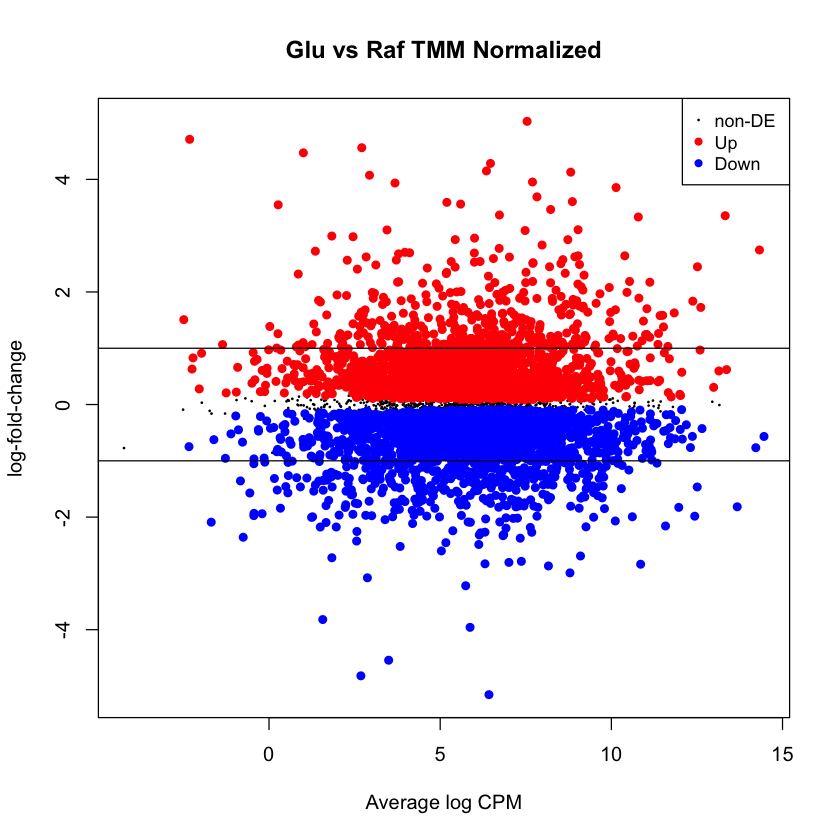

In [38]:
# see how many up and down candidates (10% FDR)
summary(decideTests(et, p.value = 0.10))

# use function from limma for MD plot
plotMD(et, main = "Glu vs Raf TMM Normalized", p.value = 0.10)
abline(h = c(-1, 1), col = "black")

### Counts by category and logFC plots

candidate n   
1 high      3666
2 med        232
3 low        116
4 no         648

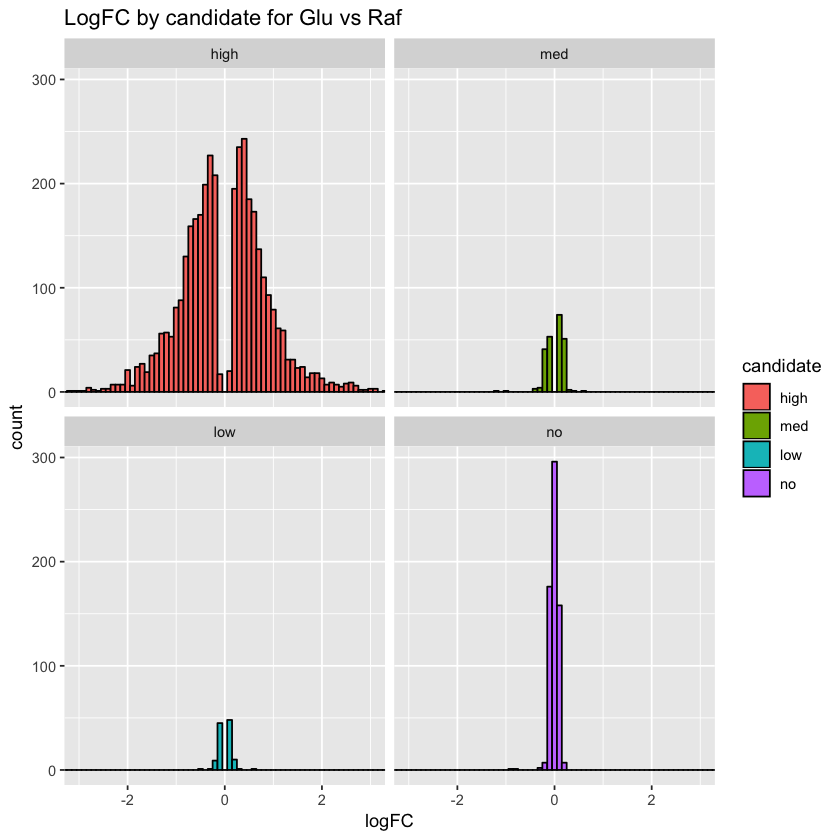

In [39]:
# see how many candidates are in each category
glu_raf %>% count(candidate)

# can also look at log2FC distributions
log2FC_plots(glu_raf, 3, "LogFC by candidate for Glu vs Raf")

### MA plots first

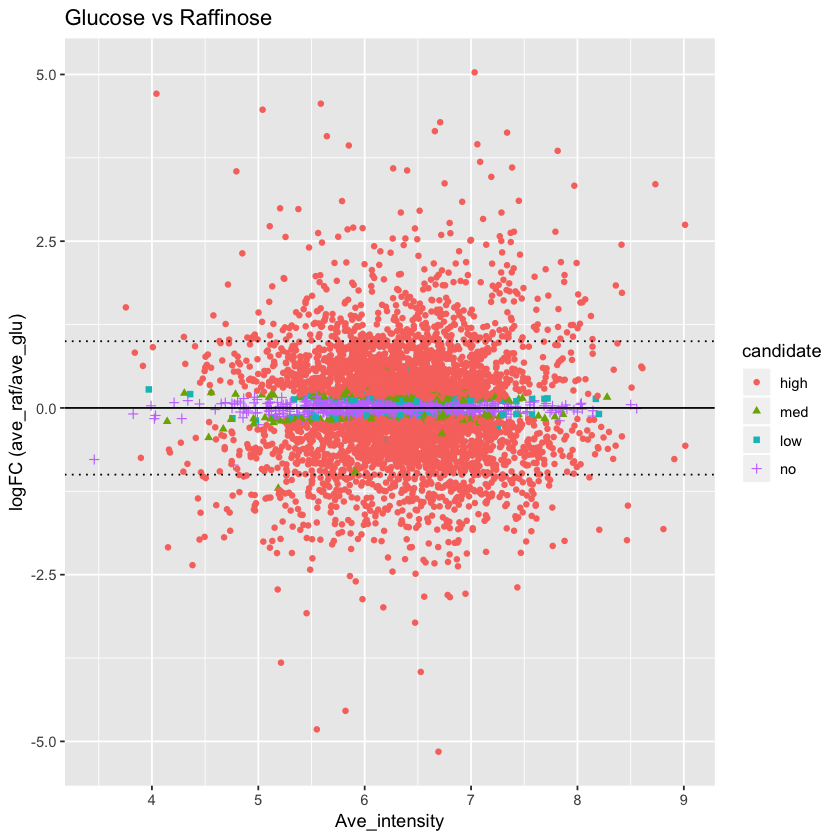

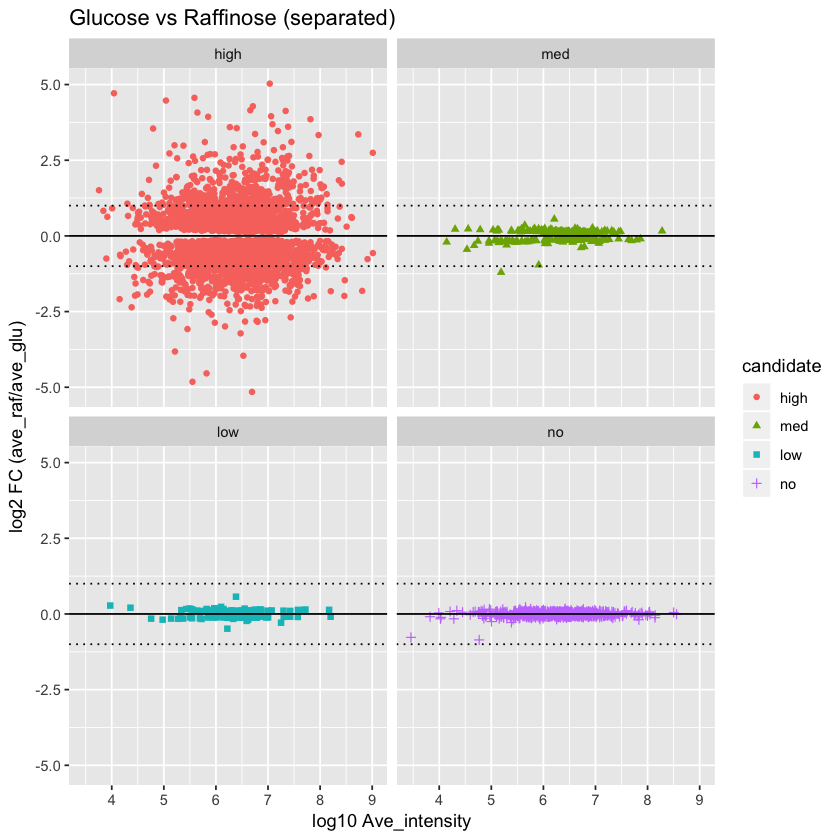

In [40]:
# MA plots for glu vs raf
MA_plots(glu_raf, "ave_glu", "ave_raf", "Glucose vs Raffinose")

### Scatter plots

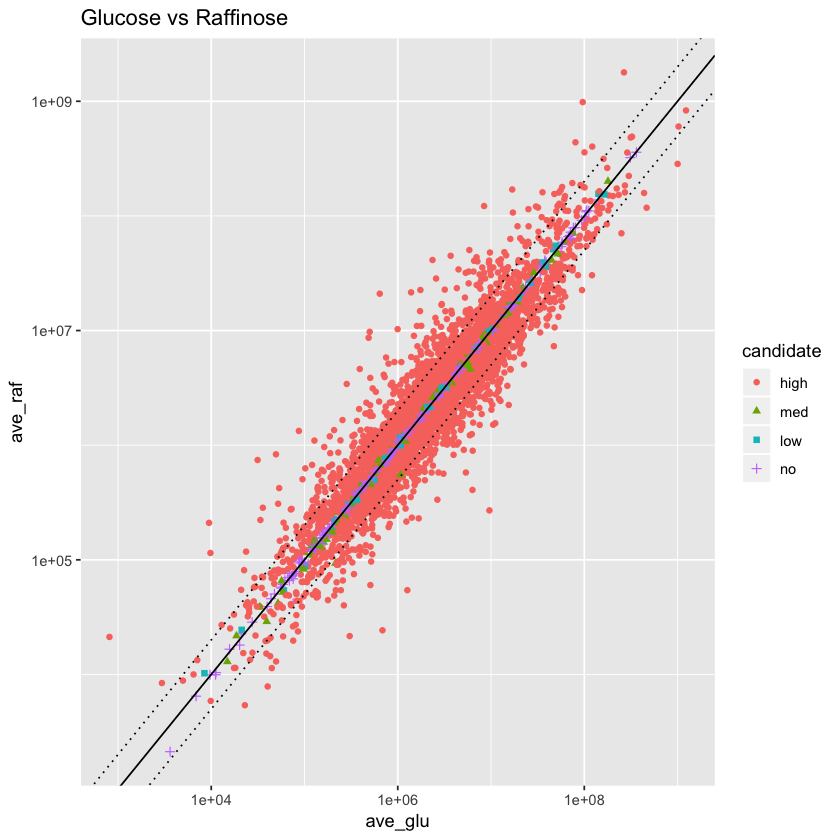

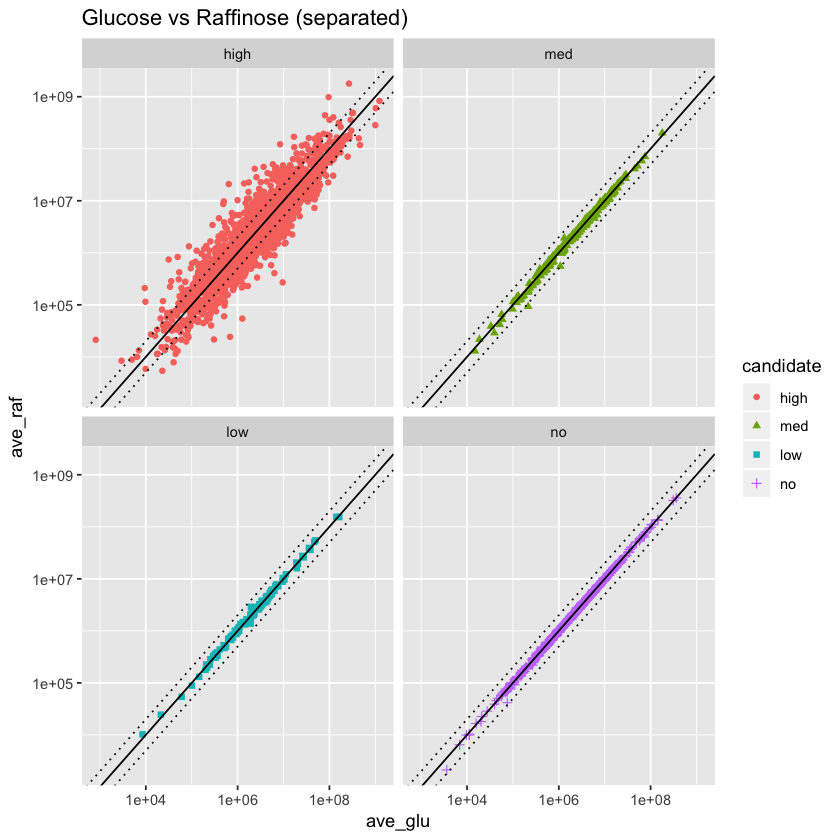

In [41]:
# scatter plots
scatter_plots(glu_raf, "ave_glu", "ave_raf", "Glucose vs Raffinose")

### Volcano plot

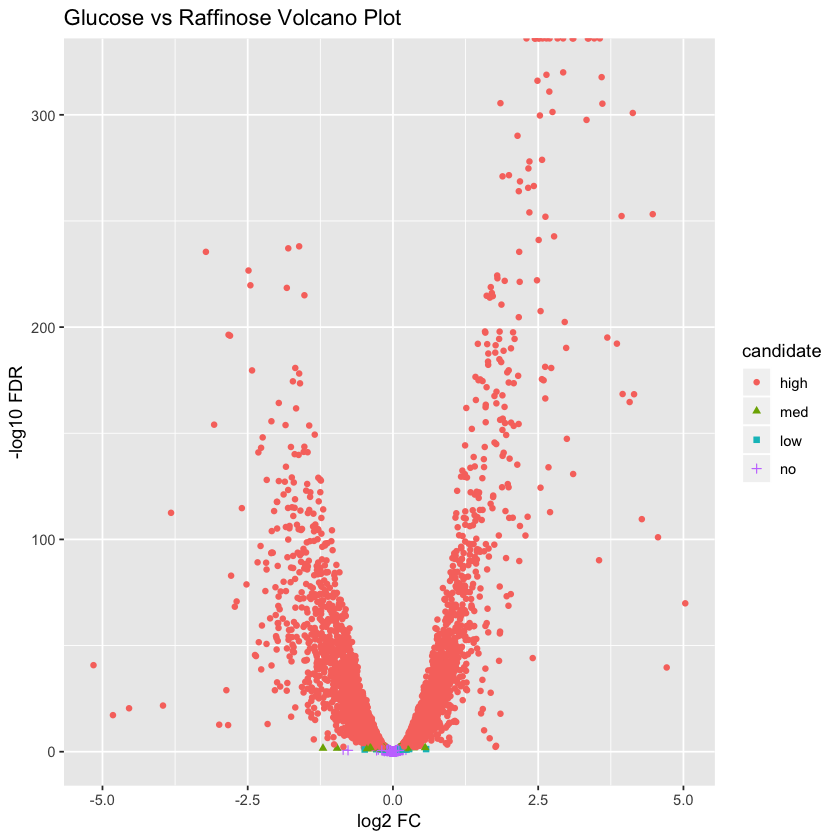

In [42]:
volcano_plot(glu_raf, "ave_glu", "ave_raf", "Glucose vs Raffinose")

### Seeing a similar pattern to the other two comparisons

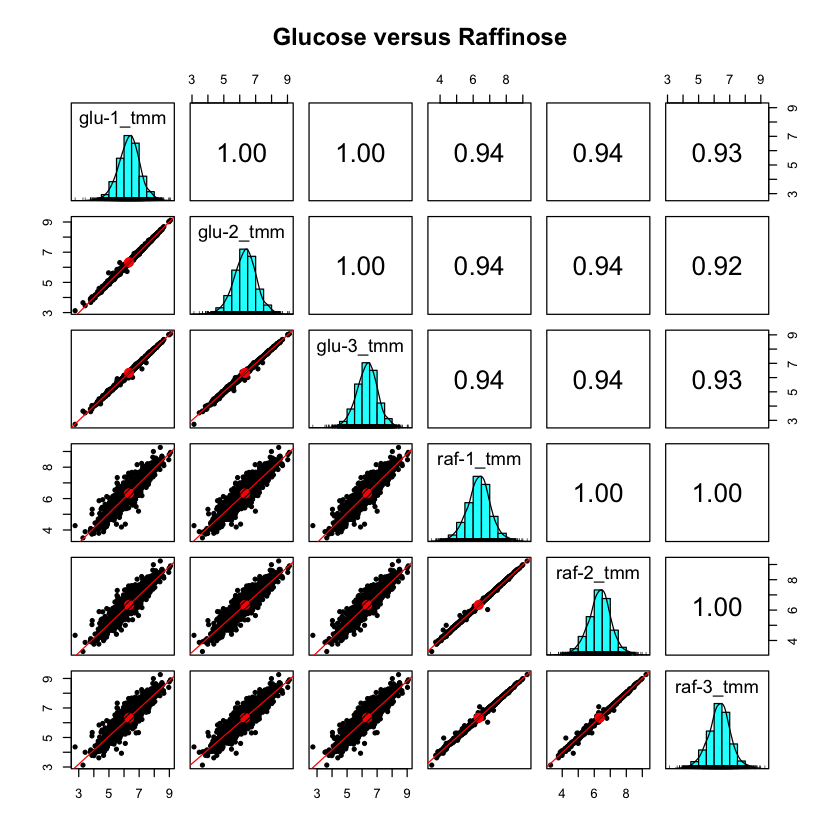

In [43]:
# compare the conditions to each other
pairs.panels(log10(tmt_tmm[c(glu, raf)]), method = "spearman", 
             lm = TRUE, main = "Glucose versus Raffinose")

### Within conditions are very tight and between conditions have a lot of scatter


# Summary

Changing the carbon source seems to have a dramatic effect of the yeast protein expression levels.

In all three comparisons, we had:
- small CV values
- very tight within condition scatter plots
- much broader scatter plots between conditions
- very high numbers of statistically significant DE candidates

The numbers of candidates are around 75% of the proteins with a basic 5% FDR cutoff. Can quantitative proteomics data be **too good**? Does changing the carbon source change the expression levels of every protein in yeast? Or is the reproducibility between biological replicates for yeast in the Gygi lab hands so good that biologically insignificant expression changes are statistically significant changes? The answer probably lies somewhere in the middle. My previous experiences with edgeR testing of TMT data suggests that the modeling is pretty conservative, so I suspect that changing the energy source for yeast is a pretty big perturbation.

This raises the open question of how to proceed when some perturbation causes wholesale protein expression changes and you have a precise method for measuring protein expression. The statistical testing will indicate that practically all proteins are changing. How to rank the candidates for hypotheses and follow up studies is an open problem in modern genomics and now in proteomics.

We will explore what different statistical tests and test options have on the numbers DE results in the next notebook. More advanced features of edgeR allow minimum fold-change criteria to be incorporated into the modeling. Different multiple testing corrections also vary from less conservative to overly conservative and might be important factors.

## Export the results and log the session

We still need to get these results back into our main results spreadsheet. We will also log the R session for our records.

In [44]:
# save the results file to add back to the main spreadsheet
results <- cbind(gal_glu, gal_raf, glu_raf)
write.table(results, "./results_files/CarbonSources_results.txt", sep = "\t", row.names = FALSE, na = " ")

In [45]:
# log the session information
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.2

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] edgeR_3.24.3    limma_3.38.3    scales_1.0.0    gridExtra_2.3  
 [5] forcats_0.3.0   stringr_1.3.1   dplyr_0.7.8     purrr_0.3.0    
 [9] readr_1.3.1     tidyr_0.8.2     tibble_2.0.1    ggplot2_3.1.0  
[13] tidyverse_1.2.1 psych_1.8.12   

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.0       locfit_1.5-9.1   lubridate_1.7.4  lattice_0.20-38 
 [5] assertthat_0.2.0 digest_0.6.18    IRdisplay_0.7.0  R6_2.3.0        
 [9] cellranger_1.1.0 plyr_1.8.4       repr_0.19.1      backports_1.1.